In [13]:
import os
import numpy as np 
import pandas as pd
import MDAnalysis as mda
import arviz as az
import pymc3 as pm
import spc_os
import spc_analysis
from spc_vis import format_plus_minus_error
from fetch_data import df_to_data_sheet
import pickle
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
import sys
import subprocess as sp
sys.path.append("..")
from src.features.build_features import get_significant
from src.visualization.handle_data import combine_posterior_variables
RANDOM_SEED = 281090

In [14]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [15]:
%mkdir ../reports/for_print

mkdir: cannot create directory ‘../reports/for_print’: File exists


In [16]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

In [17]:
plt.rcParams["text.latex.preamble"] = [
    r"\usepackage{textgreek}",
    r"\usepackage{siunitx}",  # Remember to use r'string'
    r"\usepackage{mhchem}",
    r"\usepackage{amsmath}"
]

<ipython-input-17-88f0ab63decf>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams["text.latex.preamble"] = [


# Load MD data

In [18]:
method = 'sparta_plus' # sparta_plus or ppm
nucleus = 'CA' # CA C CB N
data_size = 2000  # 70000 max data_size
model_name = 'skew_model'
infer = False

In [19]:
def load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED, xrd = False):
    if xrd:
        xrd = '_xrd'
    else:
        xrd = ''
    df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')
    mask = df_diff.dropna(axis=1).columns
    df_diff = df_diff.reindex(columns=mask).xs(nucleus, level='nuclei', axis=1).drop([33, 34, 111, 112], axis=1,errors='ignore')
    
    df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

    df_exp_o = df_exp_o.reindex(columns=mask).xs(nucleus, level='nuclei', axis=1).drop([33, 34, 111, 112], axis=1,errors='ignore')

    df_3fb5 = pd.read_pickle(processed_data_dir +
                             f'3FB5_lb/CS_{method}_3FB5_lb{xrd}.pkl')

    df_3fb5 = df_3fb5.reindex(columns=mask)#.sample(data_size,
                                          #random_state=RANDOM_SEED)
    df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1).drop([33, 34, 111, 112], axis=1,errors='ignore')

    df_5vk6 = pd.read_pickle(processed_data_dir +
                             f'5VK6_lb/CS_{method}_5VK6_lb{xrd}.pkl')

    df_5vk6 = df_5vk6.reindex(columns=mask)#.sample(data_size,
                                          #random_state=RANDOM_SEED)
    df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1).drop([33, 34, 111, 112], axis=1,errors='ignore')

    df_5vkh = pd.read_pickle(processed_data_dir +
                             f'5VKH_lb/CS_{method}_5VKH_lb{xrd}.pkl')

    df_5vkh = df_5vkh.reindex(columns=mask)#.sample(data_size,
                                          #random_state=RANDOM_SEED)
    df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1).drop([33, 34, 111, 112], axis=1,errors='ignore')

    return df_exp_o,df_3fb5, df_5vk6, df_5vkh, df_diff, mask

In [20]:
df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)

# Make histograms

In [9]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [10]:
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}

In [ ]:
for nucleus in ['CA', 'CB', 'C', 'N']:
    for method in ['shiftx2', 'sparta_plus']:
        df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)
        n = df_3fb5.shape[1]
        fig, ax = plt.subplots(n // 6 + 1, 6, figsize=(13, 15))
        ax = ax.flatten()
        for i, resid in enumerate(df_3fb5):
            sns.kdeplot(df_3fb5[resid], ax=ax[i], label='po')
            sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
            sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
            ax[i].set_title(f'{aa_dic[resid]}{resid}')
            #ax[i].set_xlabel(f'Raw CS$_{sim}$ {nucleus}')
            ax[i].set_ylabel(f'')
            ax[i].set_xlabel(f'')
            ax[i].axvline(x=df_exp_o[resid][0], c="black")
        for i in range(6 - n % 6):
            fig.delaxes(ax[-i-1])
        fig.tight_layout()
        fig.suptitle(r'Raw CS$_{sim}$' + f' {method_to_name[method]} {nuclei_to_name[nucleus]} Distributions', y =1.03, size =20)
        fig.savefig(reports_dir + f'for_print/hist_{method}_{nucleus}.png')

# Compare methods

In [11]:
nucleus = 'CA'

In [12]:
df_exp_o, df_3fb5_ppm, df_5vk6_ppm, df_5vkh_ppm, df_diff, mask = load_data_frames(processed_data_dir, 'ppm', nucleus, data_size, model_name, RANDOM_SEED)

In [13]:
df_exp_o, df_3fb5_sparta, df_5vk6_sparta, df_5vkh_sparta, df_diff, mask = load_data_frames(processed_data_dir, 'sparta_plus', nucleus, data_size, model_name, RANDOM_SEED)

In [14]:
df_exp_o, df_3fb5_shiftx, df_5vk6_shiftx, df_5vkh_shiftx, df_diff, mask = load_data_frames(processed_data_dir, 'shiftx2', nucleus, data_size, model_name, RANDOM_SEED)

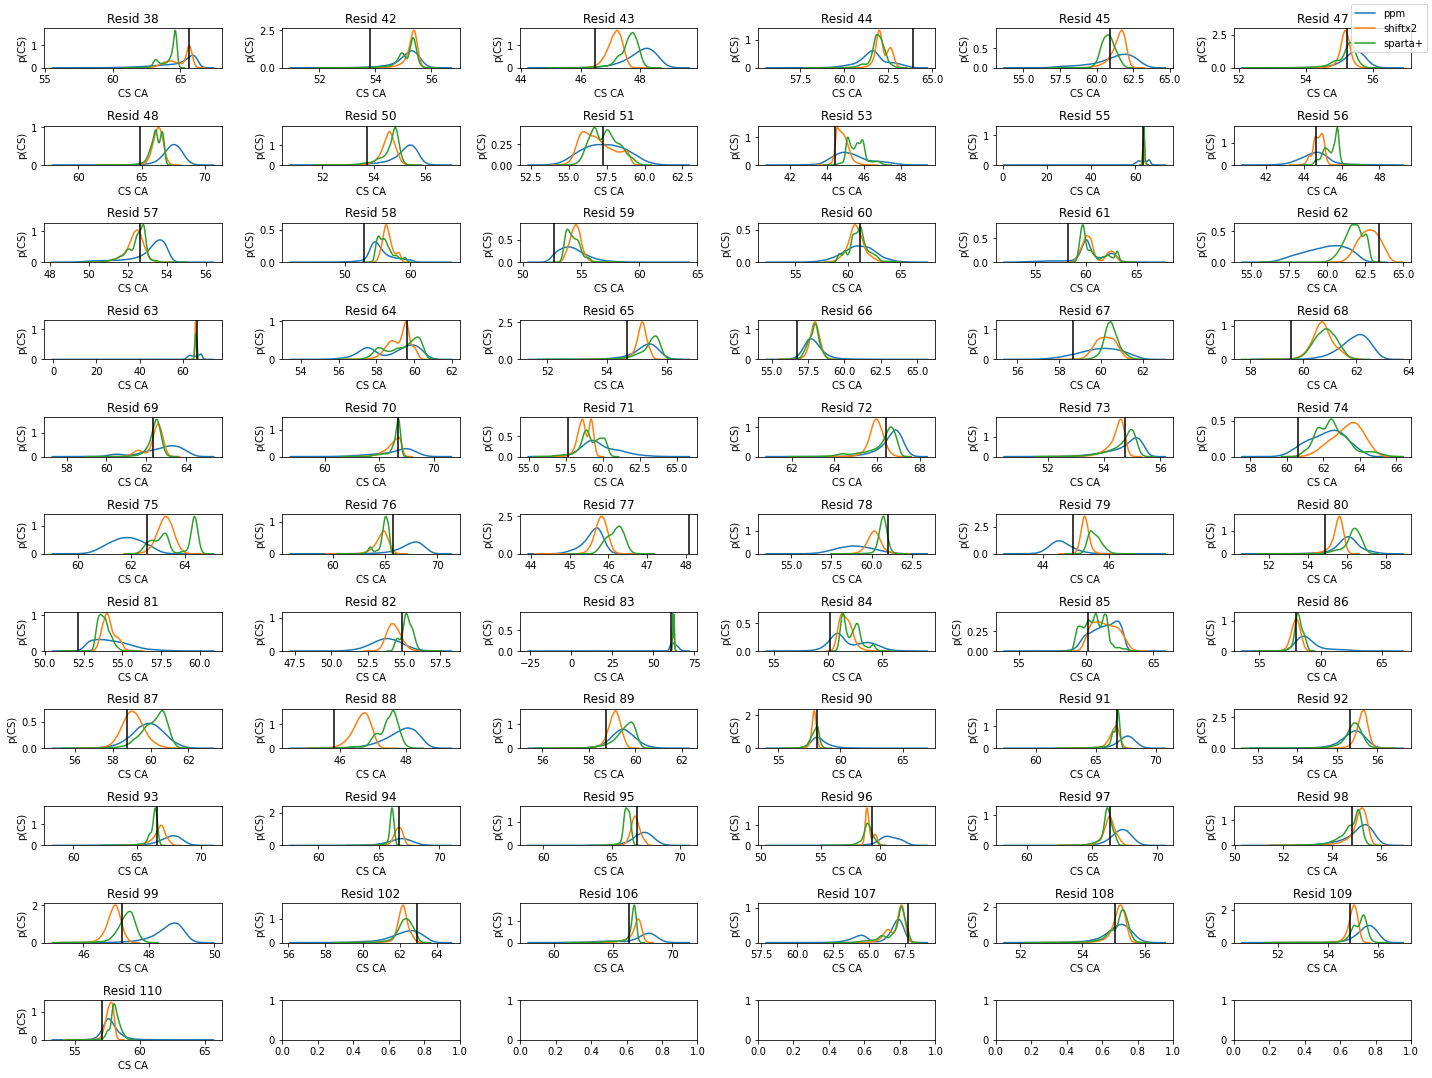

In [15]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5_ppm):
    sns.kdeplot(df_3fb5_ppm[resid], ax=ax[i], label='ppm')
    sns.kdeplot(df_3fb5_sparta[resid], ax=ax[i], label='sparta+')
    sns.kdeplot(df_3fb5_shiftx[resid], ax=ax[i], label='shifx2')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
fig.legend(labels = ['ppm', 'shiftx2', 'sparta+'])
fig.tight_layout()
fig.savefig(reports_dir + f'for_print/hist_all_open_{nucleus}.png')

# Study Inference

## Load Data 

In [166]:
methods = {}

In [167]:
nuclei = ['CA','CB','C','N']

In [168]:
for nucleus in nuclei:
    methods[nucleus] = {}
    for method in [ 'sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta_delta', 'state',
        ['PartiallyOpen', 'Fully Open'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        methods[nucleus][method]= { 'data': my_model}

<ipython-input-168-538c23285f5e>:9: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


In [169]:
for m in [ 'sparta_plus', 'shiftx2']:
    for c, a in zip([0.2, 0.2, 0.2, 0.5], nuclei):
        l = get_significant( models_dir + f"{model_name}_{m}_{a}.nc", ppm_cutoff=c)
        [ l.remove(amino_acid) for amino_acid in ['T33', 'V34','A111', 'T112'] if amino_acid in l ]
        methods[a][m]['aa'] = l

In [170]:
plt.rcParams["text.usetex"] = False

In [171]:
plt.rcParams["axes.facecolor"] = "white" #"#EAEAF2"

## Statical filtering

### SPARTA+

In [172]:
method = 'sparta_plus'

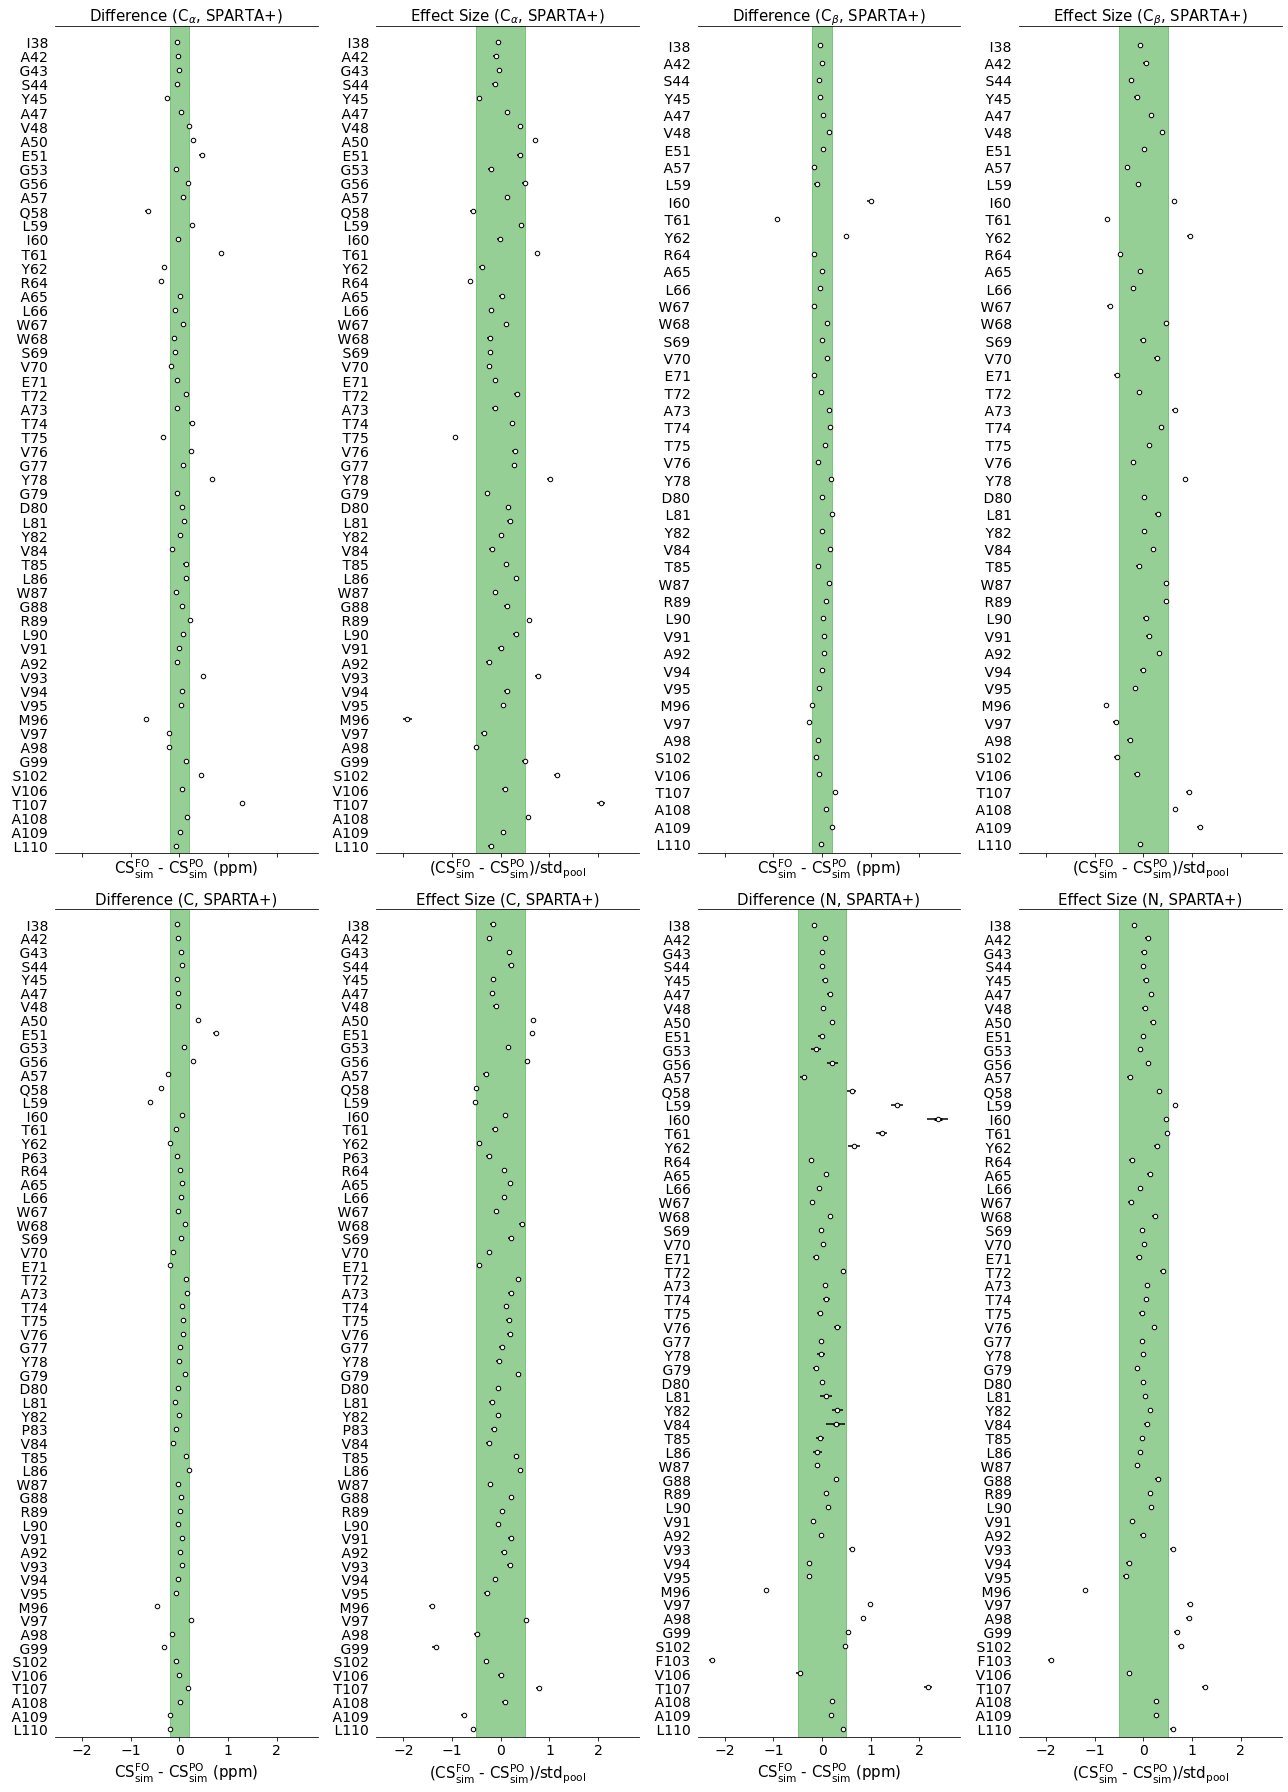

In [151]:
fig, ax = plt.subplots(2,4, figsize=(18,25), sharex=True)
ax = ax.flatten()
nucleus = 'CA'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[0])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[1])
ax[0].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[0].set_title(r'Difference (C$_\alpha$, SPARTA+)', size=15)
ax[1].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[1].set_title(r'Effect Size (C$_\alpha$, SPARTA+)', size=15)

nucleus = 'CB'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[2])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[3])
ax[2].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[2].set_title(r'Difference (C$_\beta$, SPARTA+)', size=15)
ax[3].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[3].set_title(r'Effect Size (C$_\beta$, SPARTA+)', size=15)

nucleus = 'C'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[4])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[5])
ax[4].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[4].set_title(r'Difference (C, SPARTA+)', size=15)
ax[5].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[5].set_title(r'Effect Size (C, SPARTA+)', size=15)

nucleus = 'N'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.5, 0.5), combined=True,
              var_names=[''], colors='black', ax=ax[6])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[7])
ax[6].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[6].set_title(r'Difference (N, SPARTA+)', size=15)
ax[7].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[7].set_title(r'Effect Size (N, SPARTA+)', size=15)
fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_all.png')

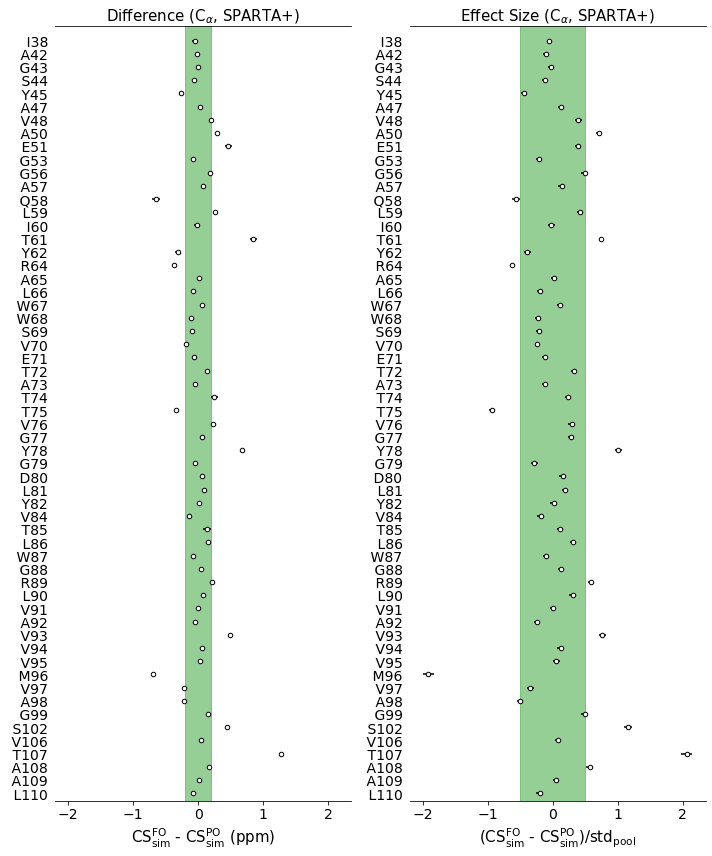

In [173]:
fig, ax = plt.subplots(1,2, figsize=(10,12), sharex=True)
ax = ax.flatten()
nucleus = 'CA'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[0])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[1])
ax[0].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[0].set_title(r'Difference (C$_\alpha$, SPARTA+)', size=15)
ax[1].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[1].set_title(r'Effect Size (C$_\alpha$, SPARTA+)', size=15)

fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_main.pdf', bbox_inches='tight')

### SHIFTX2

In [153]:
method = 'shiftx2'

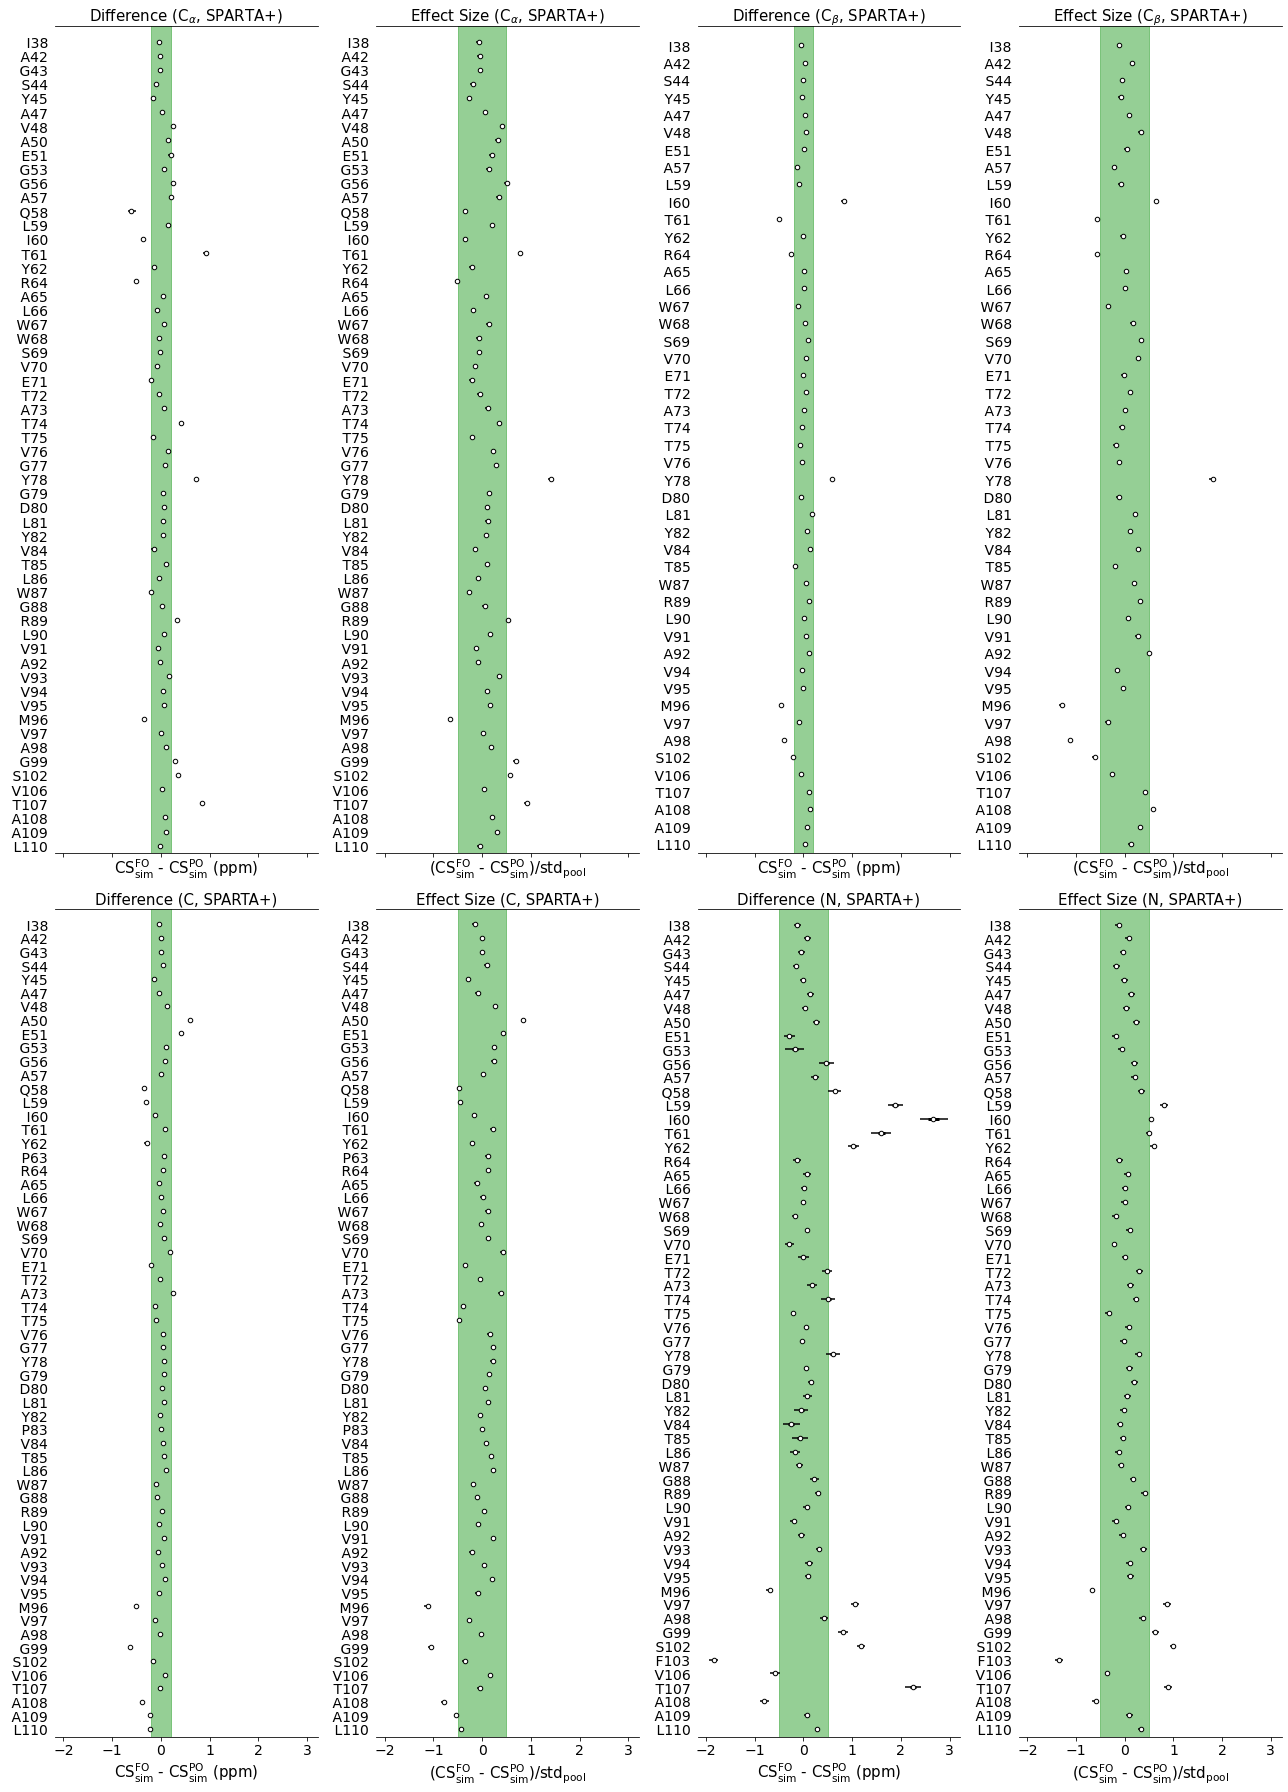

In [154]:
fig, ax = plt.subplots(2,4, figsize=(18,25), sharex=True)
ax = ax.flatten()
nucleus = 'CA'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[0])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[1])
ax[0].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[0].set_title(r'Difference (C$_\alpha$, SPARTA+)', size=15)
ax[1].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[1].set_title(r'Effect Size (C$_\alpha$, SPARTA+)', size=15)

nucleus = 'CB'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[2])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[3])
ax[2].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[2].set_title(r'Difference (C$_\beta$, SPARTA+)', size=15)
ax[3].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[3].set_title(r'Effect Size (C$_\beta$, SPARTA+)', size=15)

nucleus = 'C'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.2, 0.2), combined=True,
              var_names=[''], colors='black', ax=ax[4])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[5])
ax[4].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[4].set_title(r'Difference (C, SPARTA+)', size=15)
ax[5].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[5].set_title(r'Effect Size (C, SPARTA+)', size=15)

nucleus = 'N'
my_model = methods[nucleus][method]['data']
az.plot_forest(my_model.posterior.rename({'diff_means':''})[''], rope=(-0.5, 0.5), combined=True,
              var_names=[''], colors='black', ax=ax[6])
az.plot_forest(my_model.posterior.rename({'effect_size':''})[''], combined=True, var_names=[''], rope=(-0.5, 0.5), colors='black', ax=ax[7])
ax[6].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[6].set_title(r'Difference (N, SPARTA+)', size=15)
ax[7].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[7].set_title(r'Effect Size (N, SPARTA+)', size=15)
fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_all.png')

### T61 4 vs 3 SubUnits

In [155]:
data = {}

In [156]:
nuclei = ['CA','CB','C','N']

In [157]:
nuclei_latex = [r'C$_\alpha$', r'C$_\beta$', 'C', 'N']

In [158]:
methods = [ 'sparta_plus', 'shiftx2']

In [159]:
methods_latex = ['SPARTA+', 'SHIFTX2']

In [160]:
for nucleus in nuclei:
    data[nucleus] = {}
    for method in methods:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta_delta', 'state',
        ['PartiallyOpen', 'Fully Open'])
        data[nucleus][method]= { 'data': my_model}
    for method in [ 'sparta_plus', 'shiftx2']:
        model_path = models_dir + f"skew_model_T61_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta_delta', 'state',
        ['PartiallyOpen', 'Fully Open'])
        data[nucleus][method]['data2'] = my_model

In [161]:
diff_4SU =[
    data[nucleus][method]['data'].posterior.rename({'diff_means': nucleus_latex})[nucleus_latex].loc[:,:,'T61']
    for nucleus, nucleus_latex in zip(nuclei, nuclei_latex) for method in methods
]

In [162]:
effect_4SU =[
    data[nucleus][method]['data'].posterior.rename({'effect_size': nucleus_latex})[nucleus_latex].loc[:,:,'T61']
    for nucleus, nucleus_latex in zip(nuclei, nuclei_latex) for method in methods
]

In [163]:
diff_3SU =[
    data[nucleus][method]['data2'].posterior.rename({'diff_means': nucleus_latex})[nucleus_latex].loc[:,:,'T61']
    for nucleus, nucleus_latex in zip(nuclei, nuclei_latex) for method in methods
]

In [164]:
effect_3SU =[
    data[nucleus][method]['data2'].posterior.rename({'effect_size': nucleus_latex})[nucleus_latex].loc[:,:,'T61']
    for nucleus, nucleus_latex in zip(nuclei, nuclei_latex) for method in methods
]

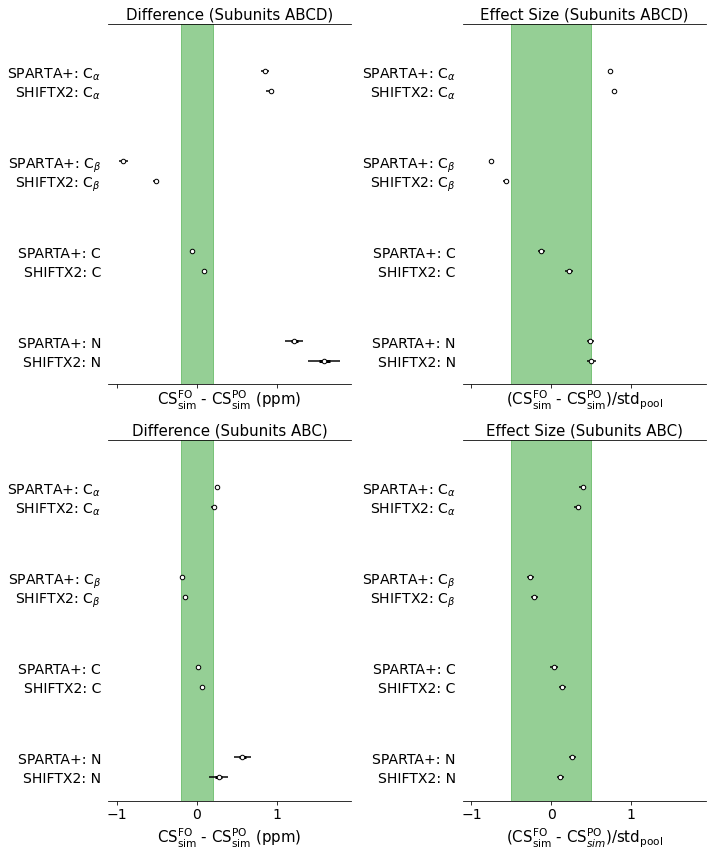

In [165]:
fig, ax = plt.subplots(2,2, figsize=(10,12), sharex=True)
ax = ax.flatten()
az.plot_forest(diff_4SU, rope=(-0.2, 0.2), combined=True,
              var_names=nuclei_latex, colors='black', ax=ax[0], model_names=methods_latex*4)
az.plot_forest(effect_4SU, rope=(-0.5, 0.5), combined=True,
              var_names=nuclei_latex, colors='black', ax=ax[1], model_names=methods_latex*4)
ax[0].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[0].set_title(r'Difference (C$_\alpha$, SPARTA+)', size=15)
ax[1].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[1].set_title(r'Effect Size (C$_\alpha$, SPARTA+)', size=15)

ax[0].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[0].set_title(r'Difference (Subunits ABCD)', size=15)
ax[1].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[1].set_title(r'Effect Size (Subunits ABCD)', size=15)

az.plot_forest(diff_3SU, rope=(-0.2, 0.2), combined=True,
              var_names=nuclei_latex, colors='black', ax=ax[2], model_names=methods_latex*4)
az.plot_forest(effect_3SU, rope=(-0.5, 0.5), combined=True,
              var_names=nuclei_latex, colors='black', ax=ax[3], model_names=methods_latex*4)
ax[2].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[2].set_title(r'Difference (C$_\alpha$, SPARTA+)', size=15)
ax[3].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim})/$std$_\mathrm{pool}$',size=15)
ax[3].set_title(r'Effect Size (C$_\alpha$, SPARTA+)', size=15)

ax[2].set_xlabel(r'CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_\mathrm{sim}$ (ppm)', size=15)
ax[2].set_title(r'Difference (Subunits ABC)', size=15)
ax[3].set_xlabel(r'(CS$^\mathrm{FO}_\mathrm{sim}$ - CS$^\mathrm{PO}_{sim})/$std$_\mathrm{pool}$',size=15)
ax[3].set_title(r'Effect Size (Subunits ABC)', size=15)

fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/statistical_filtering_{model_name}_{method}_T61.png')

## Markers

## Final

### All residues

In [100]:
methods = {}

In [101]:
nuclei = ['CA','CB','C','N']

In [102]:
for nucleus in nuclei:
    print(nucleus)
    methods[nucleus] = {}
    for method in ['sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta_delta', 'state',
        ['Partially Open', 'Fully Open'])
        methods[nucleus][method]= { 'data': my_model}

CA


<ipython-input-102-de67a370bc13>:7: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


CB
C
N


In [103]:
for m in [ 'sparta_plus', 'shiftx2']:
    for c, a in zip([0.2, 0.2, 0.2, 0.5], nuclei):
        l = get_significant( models_dir + f"{model_name}_{m}_{a}.nc", ppm_cutoff=c)
        [ l.remove(amino_acid) for amino_acid in ['T33', 'V34','A111', 'T112'] if amino_acid in l ]
        methods[a][m]['aa'] = l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-103-f180812f71cf>", line 3, in <module>
    l = get_significant( models_dir + f"{model_name}_{m}_{a}.nc", ppm_cutoff=c)
  File "../src/features/build_features.py", line 120, in get_significant
    sim = az.summary(my_model)
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/arviz/stats/stats.py", line 1226, in summary
    mcse_mean, mcse_sd, ess_mean, ess_sd, ess_bulk, ess_tail, r_hat = xr.apply_ufunc(
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/xarray/core/computation.py", line 1092, in apply_ufunc
    return apply_dataset_vfunc(
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.

TypeError: object of type 'NoneType' has no len()

In [ ]:
resids = list(set(methods['CA']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['CB']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['N']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['C']['sparta_plus']['data'].posterior.resid.to_index()) 
             )

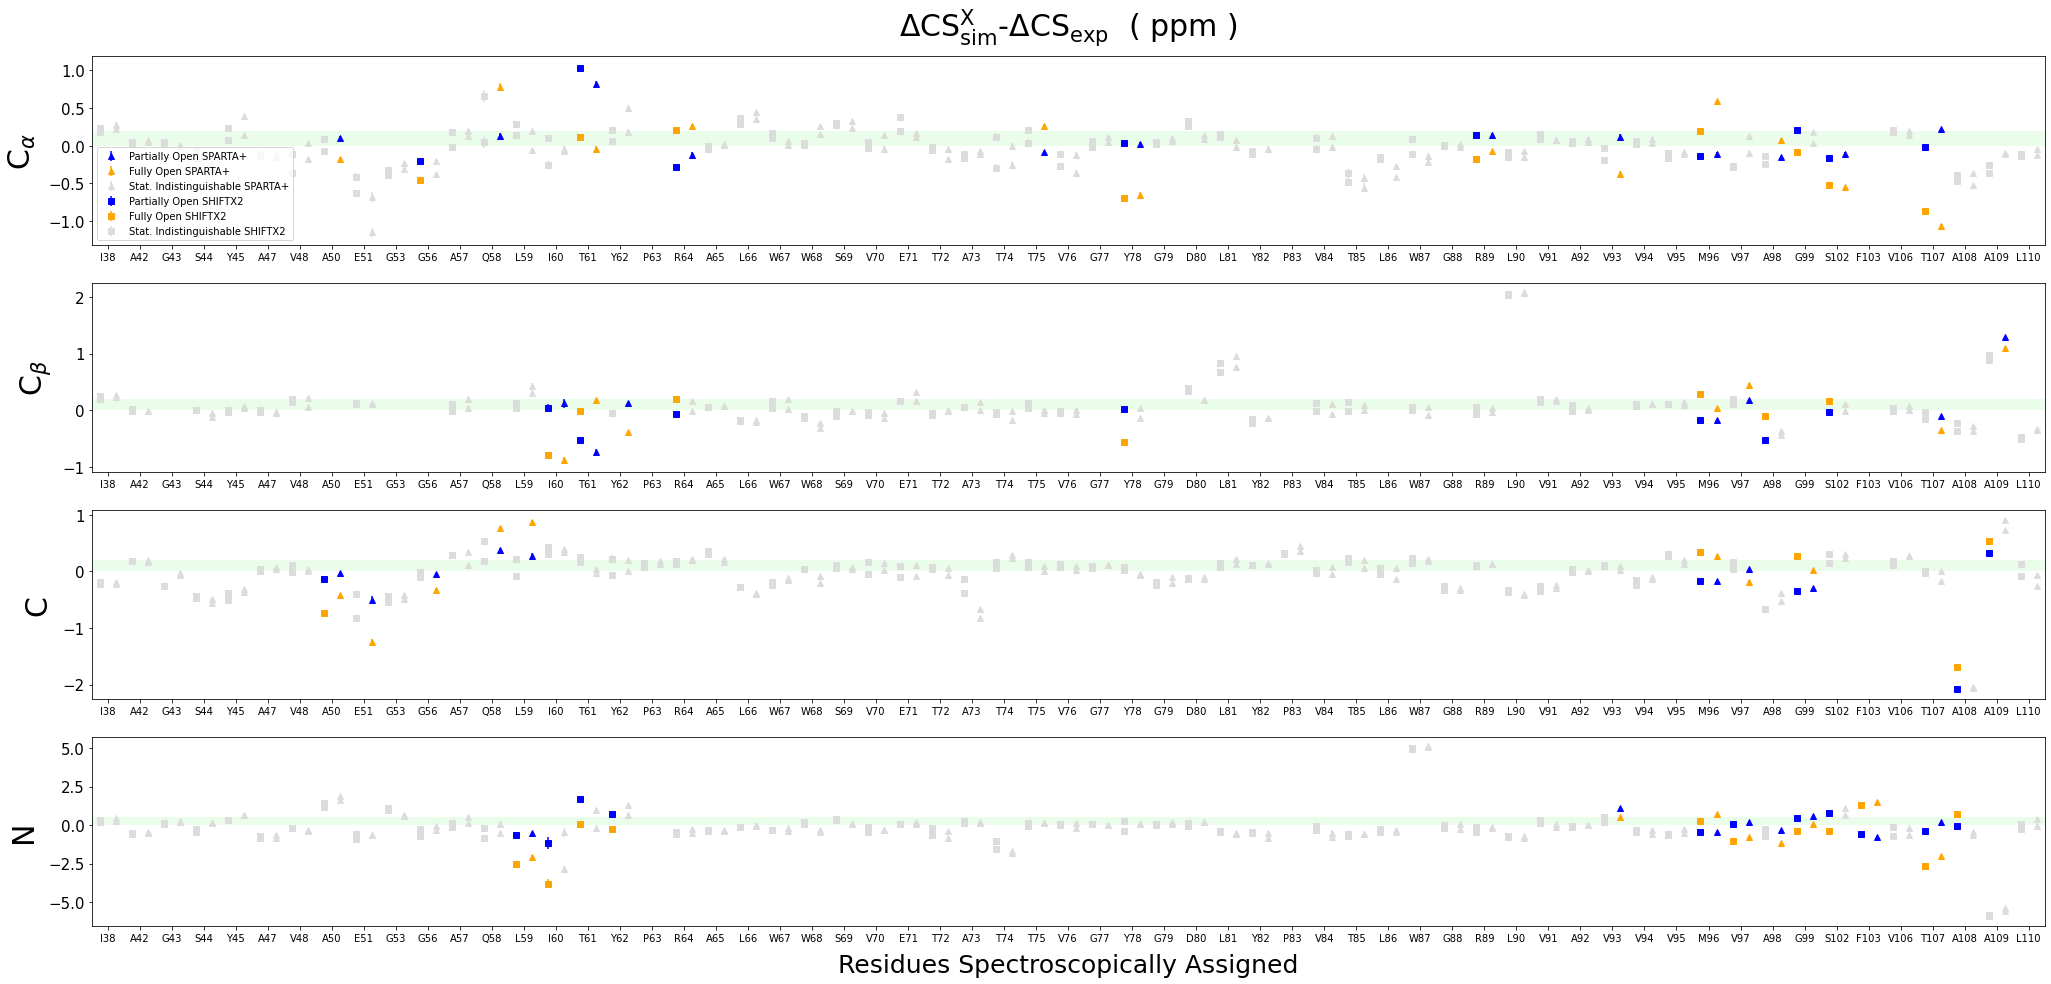

In [66]:
fig, ax = plt.subplots(4, 1, figsize=(35,16))
 
nuclei = ['CA','CB','C','N']
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}
color_grey = 'gainsboro'

resids = list(set(methods['CA']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['CB']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['N']['sparta_plus']['data'].posterior.resid.to_index()) |
              set(methods['C']['sparta_plus']['data'].posterior.resid.to_index()) 
             )

resids = [ aa_dic[r]+str(r) for r in sorted([ int(r[1:]) for r in resids]) ]
x_to_aa = { a:j for j,a in enumerate(resids) }


for method, method_name, marker,shift in zip(['sparta_plus', 'shiftx2'],
                               ['SPARTA+', 'SHIFTX2'],
                               ['^','s'],
                                [+0.25, -0.25]
                                     ):
    for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Partially Open").delta_delta.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].errorbar(x+shift,data, yerr=err, ls ='', marker=marker, color='blue', label = f'Partially Open {method_name}')
        
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Fully Open").delta_delta.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].errorbar(x+shift,data, yerr=err, ls ='', marker=marker, color='orange', label = f'Fully Open {method_name}')
        
        aa = methods[nucleus][method]['aa']
        aa = list(set(methods[nucleus][method]['data'].posterior.resid.to_index())-set(aa))
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Partially Open").delta_delta.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].errorbar(x+shift,data, yerr=err, ls ='', marker=marker, color=color_grey, label = f'Stat. Indistinguishable {method_name}')
        
        aa = methods[nucleus][method]['aa']
        aa = list(set(methods[nucleus][method]['data'].posterior.resid.to_index())-set(aa))
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Fully Open").delta_delta.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].errorbar(x+shift,data, yerr=err, ls ='', marker=marker, color=color_grey)

        x = np.arange(len(resids))
        ax[i].set_xticks(x) # Set tick positions and corresponding labels
        _ = ax[i].set_xticklabels(resids, size=10)
        ax[i].set_ylabel(nuclei_to_name[nucleus], size=30, labelpad=10)
        ax[i].tick_params(axis='y', which='major', labelsize=15)
        ax[i].set_xlim([-0.5,len(x)-0.5])
        ax[i].axhspan(0,cutoff, facecolor='palegreen', alpha=.1)
        
ax[0].set_title(r'$\Delta$CS$_\mathrm{sim}^\mathrm{X}$-$\Delta$CS$_\mathrm{exp}$  ( ppm )', size = 30, pad=20)
ax[-1].set_xlabel('Residues Spectroscopically Assigned', size=25, labelpad=10)
ax[0].legend()
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_all_print.png', bbox_inches='tight')

### Residues  in Common

In [104]:
methods = {}

In [105]:
nuclei = ['CA','CB','C','N']

In [106]:
for nucleus in nuclei:
    methods[nucleus] = {}
    print(nucleus)
    for method in [ 'sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c_abs', 'mean_fo_c_abs'], 'delta_delta_abs', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_o_abs', 'mean_fo_o_abs'], 'delta_delta_o_abs', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        methods[nucleus][method]= { 'data': my_model}

CA


<ipython-input-106-1f5fb33b005d>:13: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


CB
C
N


In [107]:
for m in [ 'sparta_plus', 'shiftx2']:
    for c, a in zip([0.2, 0.2, 0.2, 0.5], nuclei):
        l = get_significant( models_dir + f"{model_name}_{m}_{a}.nc", ppm_cutoff=c)
        [ l.remove(amino_acid) for amino_acid in ['T33', 'V34','A111', 'T112'] if amino_acid in l ]
        methods[a][m]['aa'] = l

Exception ignored in: <function ReaderBase.__del__ at 0x7fa3db4055e0>
Traceback (most recent call last):
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py", line 2152, in __del__
    self.close()
  File "/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py", line 179, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


In [108]:
from matplotlib import rcParams
#rcParams['font.family'] = ''

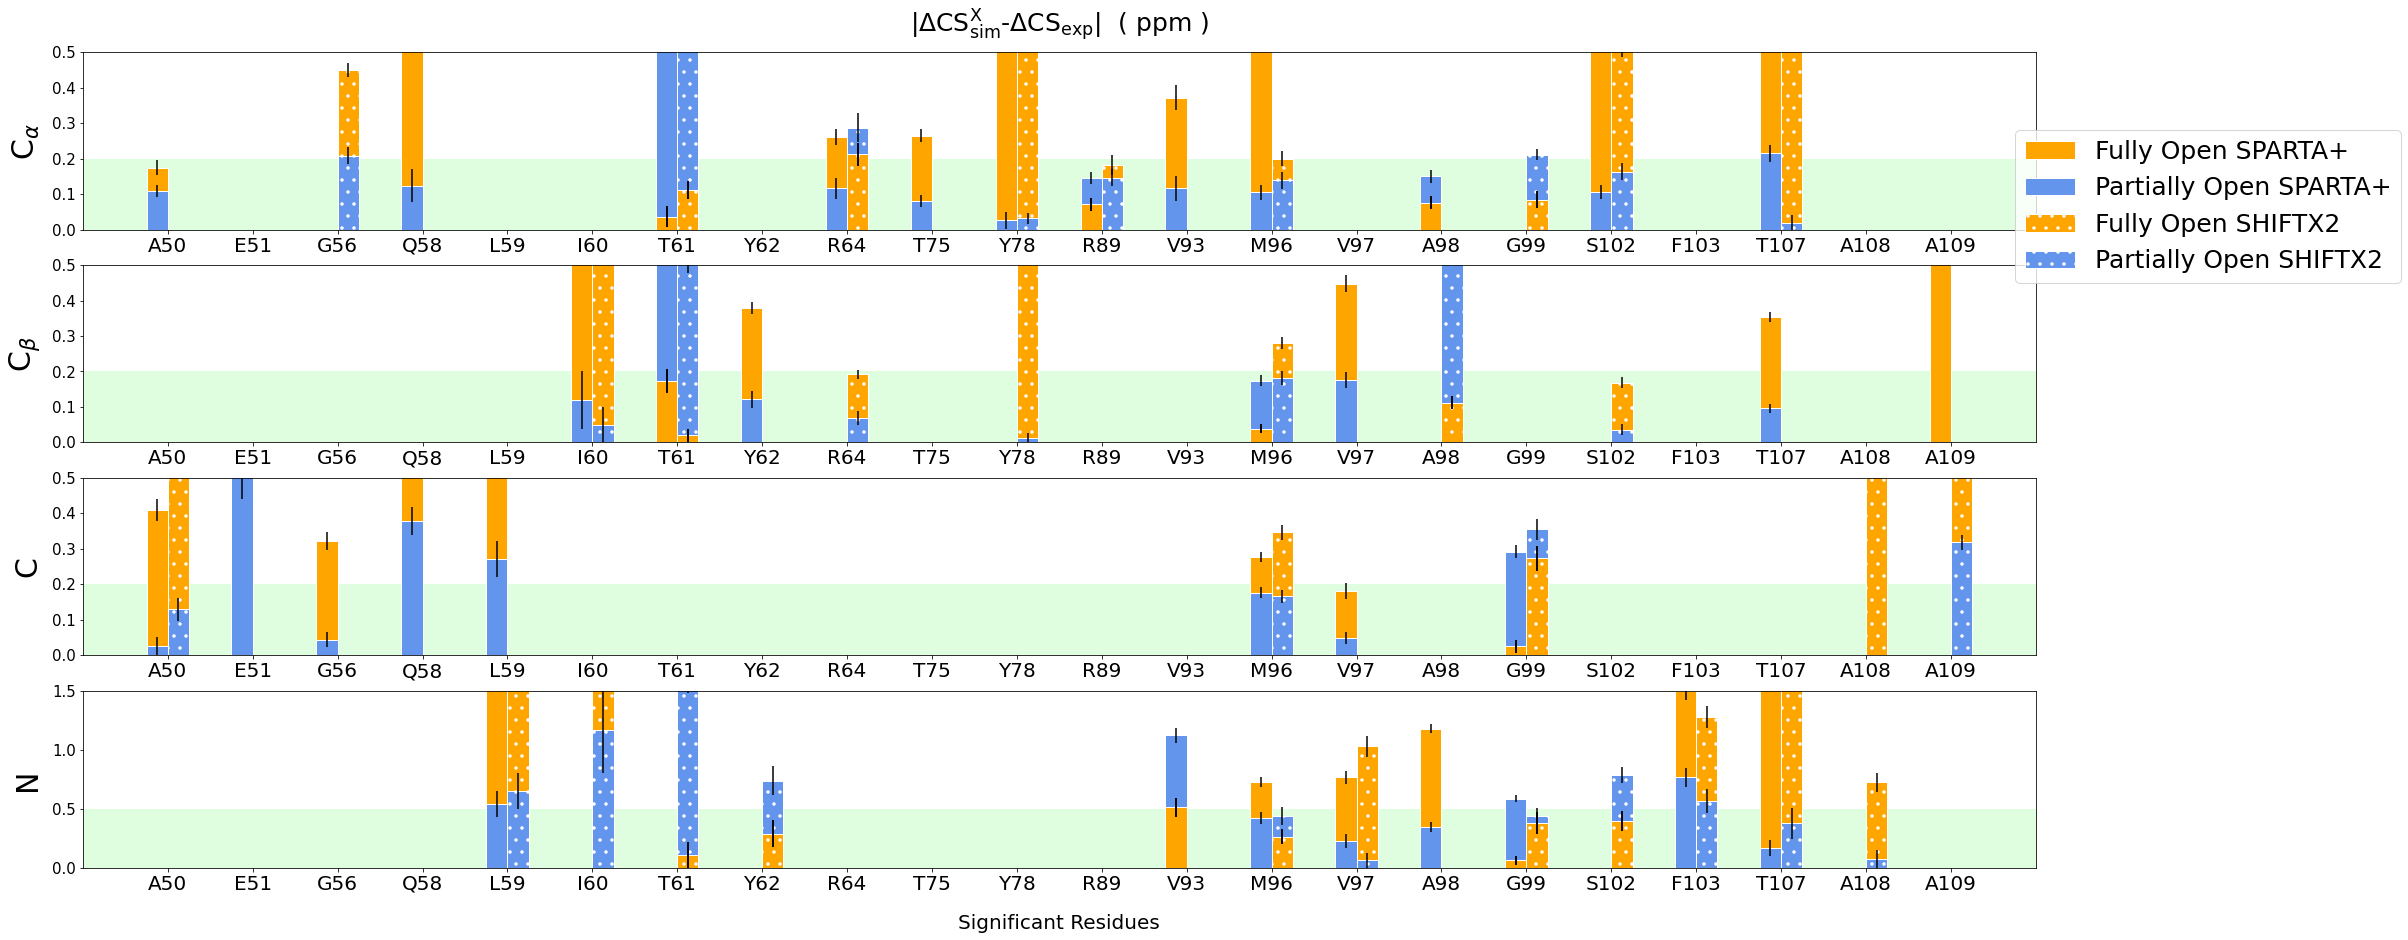

In [109]:
fig, ax = plt.subplots(4, 1, figsize=(35,15.))
 
nuclei = ['CA','CB','C','N']
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}
color_grey = 'gainsboro'

resids = list(set(methods['CA']['shiftx2']['aa']) | 
              set(methods['CA']['sparta_plus']['aa']) | 
              set(methods['CB']['shiftx2']['aa']) | 
              set(methods['CB']['sparta_plus']['aa']) | 
              set(methods['C']['shiftx2']['aa']) | 
              set(methods['C']['sparta_plus']['aa']) | 
              set(methods['N']['shiftx2']['aa']) | 
              set(methods['N']['sparta_plus']['aa']) 
)

resids = [ aa_dic[r]+str(r) for r in sorted([ int(r[1:]) for r in resids]) ]
x_to_aa = { a:j for j,a in enumerate(resids) }

for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        ax[i].axhspan(0,cutoff, facecolor='palegreen', alpha=.3)
for method, method_name, pattern, shift in zip(['sparta_plus', 'shiftx2'],
                               ['SPARTA+', 'SHIFTX2'],
                               [None, '.'],
                                [-0.125, +0.125]
                                     ):
    for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        if i == 0:
            my_label = f'Fully Open {method_name}'
        else:
            my_label = None

        
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Fully Open").delta_delta_abs.loc[:,:,aa])
        err0 = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data0 = (data['hdi_97%'] + data['hdi_3%'])/2
        x0 = np.array([x_to_aa[a] for a in aa])
        ax[i].bar(x0+shift,data0, yerr=err0, color='orange', label = my_label, hatch=pattern, edgecolor='w', width =0.25)
        
        if i == 0:
            my_label = f'Partially Open {method_name}'
        else:
            my_label = None
                
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Partially Open").delta_delta_abs.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].bar(x+shift,data, yerr=err, color='cornflowerblue', label = my_label, hatch=pattern, edgecolor='w', width =0.25)
        
        mask = data0 < data
        ax[i].bar(x0[mask]+shift,data0[mask], yerr=err0[mask], color='orange', hatch=pattern, edgecolor='w', width =0.25)
        
        x = np.arange(len(resids))
        ax[i].set_xticks(x) # Set tick positions and corresponding labels
        _ = ax[i].set_xticklabels(resids, size=20)
        ax[i].set_ylabel(nuclei_to_name[nucleus], size=30, labelpad=10)
        ax[i].tick_params(axis='y', which='both', labelsize=15)
        ax[i].set_xlim([-1,len(x)])
        #o_ax[i].set_ylim(bottom=0)
        
ax[0].set_ylim([0,0.5])
ax[1].set_ylim([0,0.5])        
ax[2].set_ylim([0,0.5])
ax[3].set_ylim([0,1.5])        
ax[0].set_title(r'$|\Delta$CS$_\mathrm{sim}^\mathrm{X}$-$\Delta$CS$_\mathrm{exp}|$  ( ppm )', size = 25, pad=20)
ax[-1].set_xlabel('Significant Residues', size=20, labelpad=20)
fig.legend(bbox_to_anchor=(1.05,0.82), fontsize=25)
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_markers_print.png', bbox_inches='tight')

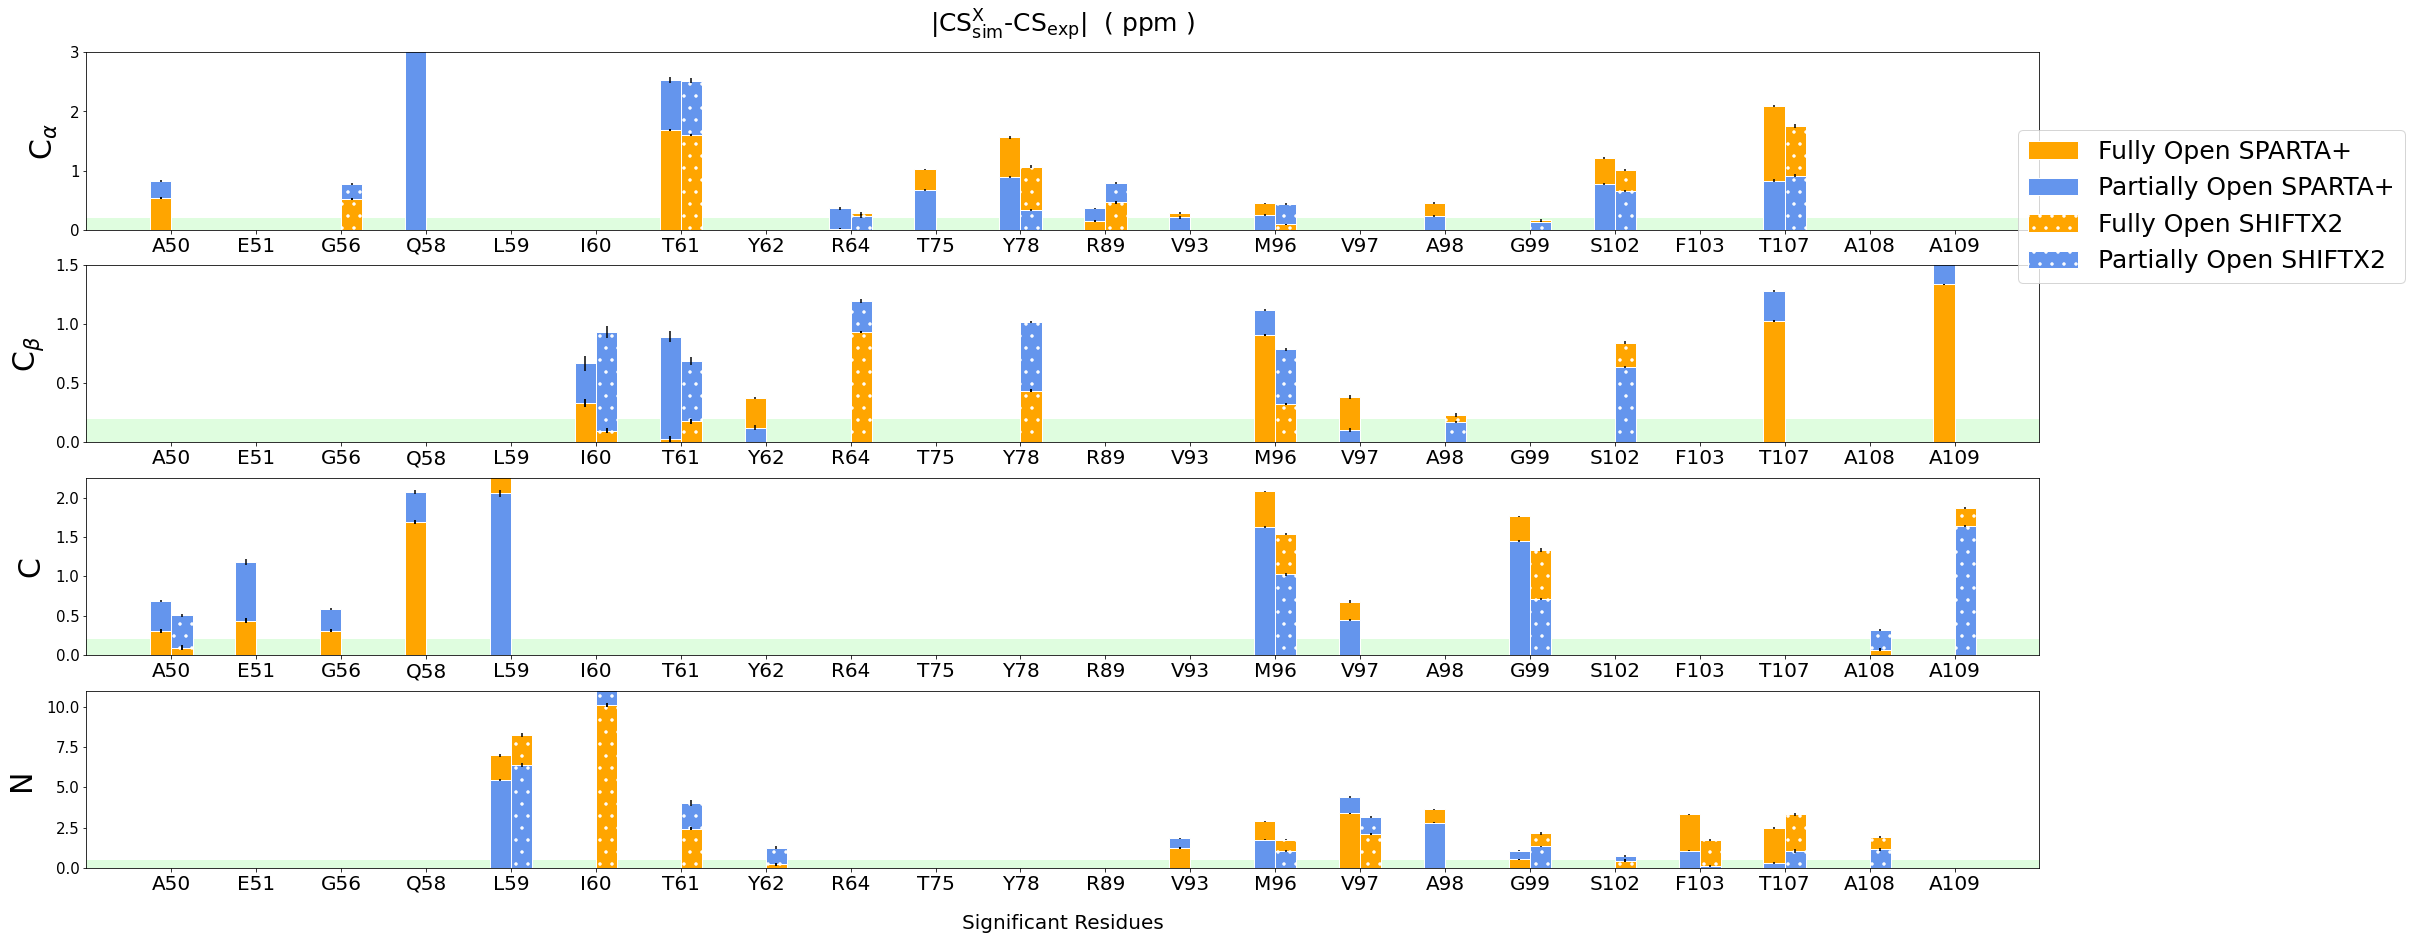

In [110]:
fig, ax = plt.subplots(4, 1, figsize=(35,15.))
 
nuclei = ['CA','CB','C','N']
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}
color_grey = 'gainsboro'

resids = list(set(methods['CA']['shiftx2']['aa']) | 
              set(methods['CA']['sparta_plus']['aa']) | 
              set(methods['CB']['shiftx2']['aa']) | 
              set(methods['CB']['sparta_plus']['aa']) | 
              set(methods['C']['shiftx2']['aa']) | 
              set(methods['C']['sparta_plus']['aa']) | 
              set(methods['N']['shiftx2']['aa']) | 
              set(methods['N']['sparta_plus']['aa']) 
)

resids = [ aa_dic[r]+str(r) for r in sorted([ int(r[1:]) for r in resids]) ]
x_to_aa = { a:j for j,a in enumerate(resids) }

for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        ax[i].axhspan(0,cutoff, facecolor='palegreen', alpha=.3)
        
for method, method_name, pattern, shift in zip(['sparta_plus', 'shiftx2'],
                               ['SPARTA+', 'SHIFTX2'],
                               [None, '.'],
                                [-0.125, +0.125]
                                     ):
    for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        if i == 0:
            my_label = f'Fully Open {method_name}'
        else:
            my_label = None

        
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Fully Open").delta_delta_o_abs.loc[:,:,aa])
        err0 = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data0 = (data['hdi_97%'] + data['hdi_3%'])/2
        x0 = np.array([x_to_aa[a] for a in aa])
        ax[i].bar(x0+shift,data0, yerr=err0, color='orange', label = my_label, hatch=pattern, edgecolor='w', width =0.25)
        
        if i == 0:
            my_label = f'Partially Open {method_name}'
        else:
            my_label = None
                
        aa = methods[nucleus][method]['aa']
        data = az.summary(methods[nucleus][method]['data'].posterior.sel(state="Partially Open").delta_delta_o_abs.loc[:,:,aa])
        err = data['hdi_97%']-(data['hdi_97%'] + data['hdi_3%'])/2.
        data = (data['hdi_97%'] + data['hdi_3%'])/2.
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].bar(x+shift,data, yerr=err, color='cornflowerblue', label = my_label, hatch=pattern, edgecolor='w', width =0.25)
        
        mask = data0 < data
        ax[i].bar(x0[mask]+shift,data0[mask], yerr=err0[mask], color='orange', hatch=pattern, edgecolor='w', width =0.25)
        
        x = np.arange(len(resids))
        ax[i].set_xticks(x) # Set tick positions and corresponding labels
        _ = ax[i].set_xticklabels(resids, size=20)
        ax[i].set_ylabel(nuclei_to_name[nucleus], size=30, labelpad=10)
        ax[i].tick_params(axis='y', which='both', labelsize=15)
        ax[i].set_xlim([-1,len(x)])
        #o_ax[i].set_ylim(bottom=0)
        
ax[0].set_ylim([0,3])
ax[1].set_ylim([0,1.5])        
ax[2].set_ylim([0,2.25])
ax[3].set_ylim([0,11.])        
ax[0].set_title(r'$|$CS$_\mathrm{sim}^\mathrm{X}$-CS$_\mathrm{exp}|$  ( ppm )', size = 25, pad=20)
ax[-1].set_xlabel('Significant Residues', size=20, labelpad=20)
fig.legend(bbox_to_anchor=(1.05,0.82), fontsize=25)
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_markers_no_refernce_print.png', bbox_inches='tight')

### XRD

In [81]:
nuclei = ['CA', 'CB', 'C', 'N']

In [82]:
methods = ['sparta_plus', 'shiftx2']

In [83]:
data = {}
for nucleus in nuclei:
    data[nucleus] = {}
    for method in methods:
        data[nucleus][method] = {}
        df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, 1, model_name, RANDOM_SEED)
        for df in [df_exp_o,df_3fb5, df_5vk6, df_5vkh, df_diff]:
            df = df.drop([33, 34, 111, 112], axis=1,errors='ignore')
        data[nucleus][method]['Open'] = df_3fb5
        data[nucleus][method]['Fully Open'] = df_5vk6
        data[nucleus][method]['Closed'] = df_5vkh
        data[nucleus][method]['Open exp'] = df_exp_o
        data[nucleus][method]['Diff exp'] = df_diff
        data[nucleus][method]['resids'] = [ aa_dic[a]+str(a) for a in df_5vkh.columns]

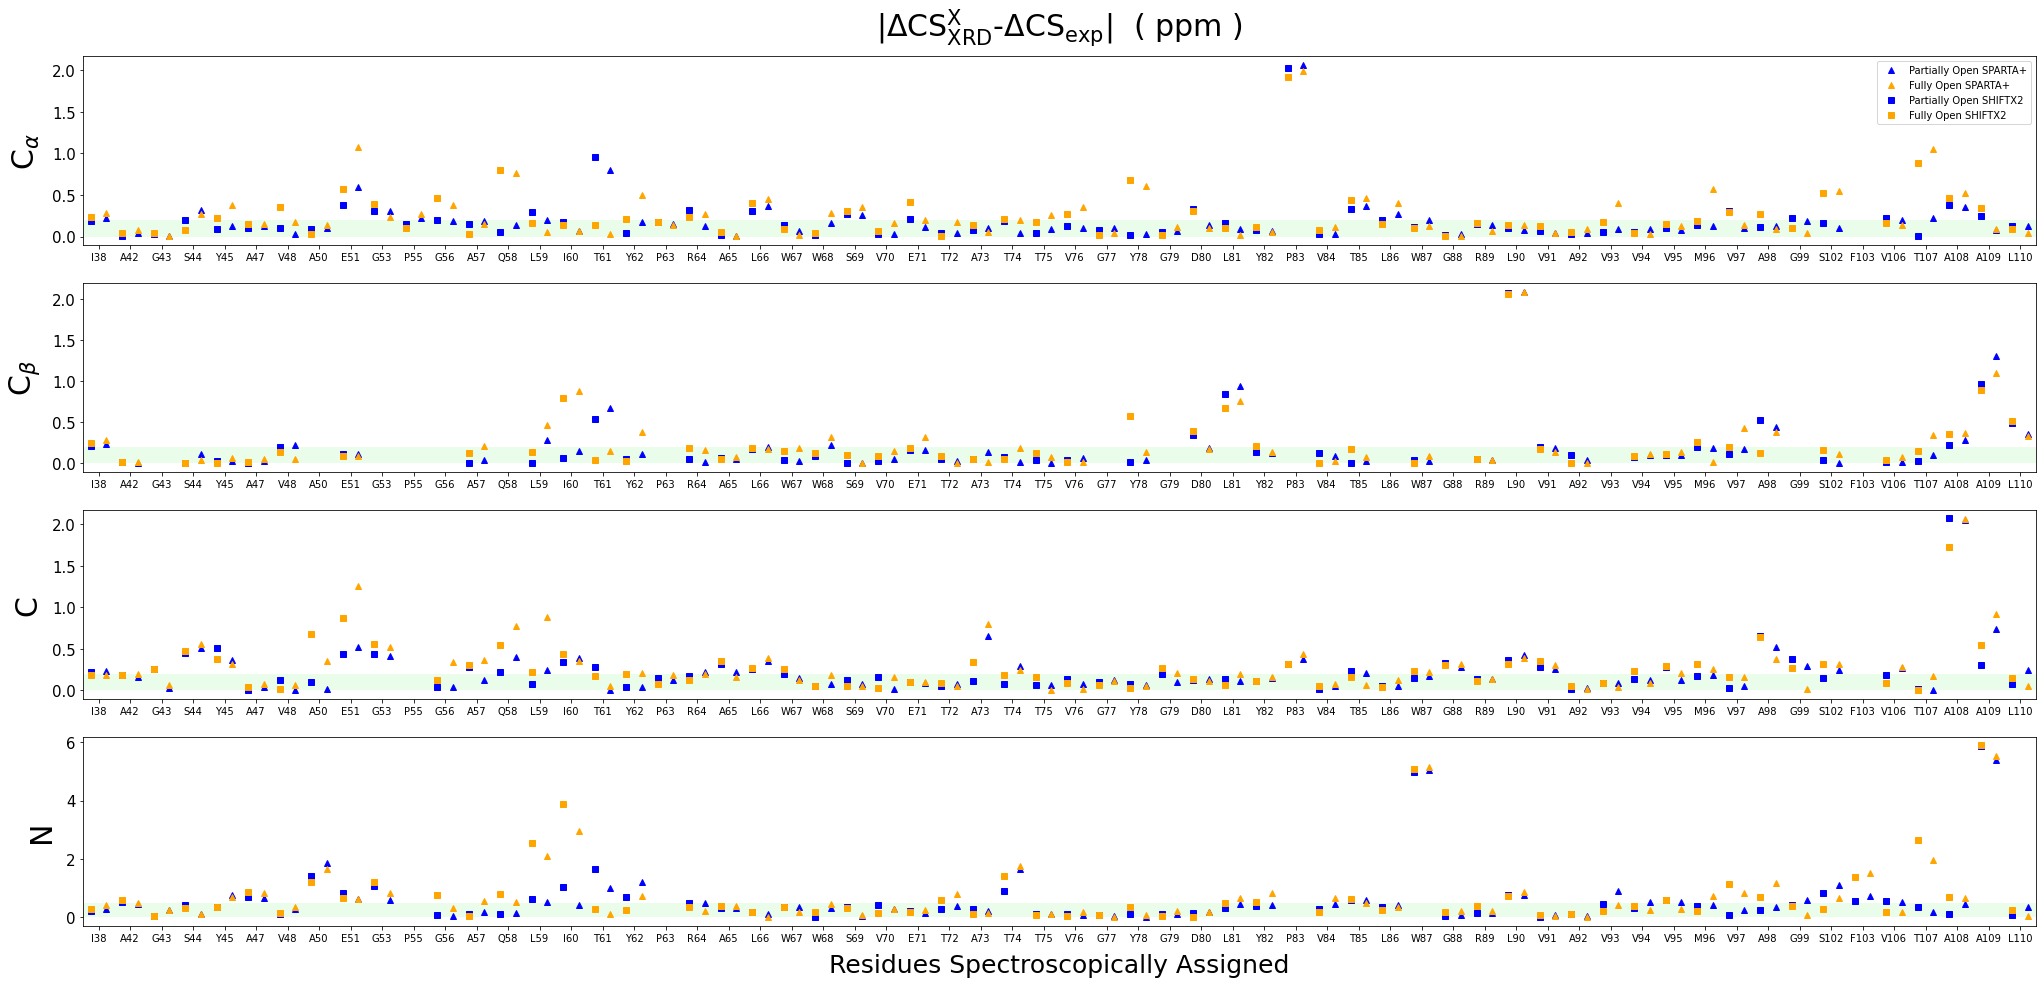

In [84]:
fig, ax = plt.subplots(4, 1, figsize=(35,16))
 

nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}
color_grey = 'gainsboro'

resids = list(set(data['CA']['sparta_plus']['resids']) |
              set(data['CB']['sparta_plus']['resids']) |
              set(data['N']['sparta_plus']['resids']) |
              set(data['C']['sparta_plus']['resids']) 
             )

resids = [ aa_dic[r]+str(r) for r in sorted([ int(r[1:]) for r in resids]) ]
x_to_aa = { a:j for j,a in enumerate(resids) }


for method, method_name, marker,shift in zip(methods,
                               ['SPARTA+', 'SHIFTX2'],
                               ['^','s'],
                                [+0.25, -0.25]
                                     ):
    for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        aa = data[nucleus][method]['resids']
        y = data[nucleus][method]['Open'].mean() - data[nucleus][method]['Closed'].mean() - (data[nucleus][method]['Diff exp'].mean())
        y = np.abs(y)
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].plot(x+shift,y, ls ='', marker=marker, color='blue', label = f'Partially Open {method_name}')
        y = data[nucleus][method]['Fully Open'].mean() - data[nucleus][method]['Closed'].mean() - (data[nucleus][method]['Diff exp'].mean())
        y = np.abs(y)
        ax[i].plot(x+shift,y, ls ='', marker=marker, color='Orange', label = f'Fully Open {method_name}')
        

        x = np.arange(len(resids))
        ax[i].set_xticks(x) # Set tick positions and corresponding labels
        _ = ax[i].set_xticklabels(resids, size=10)
        ax[i].set_ylabel(nuclei_to_name[nucleus], size=30, labelpad=10)
        ax[i].tick_params(axis='y', which='major', labelsize=15)
        ax[i].set_xlim([-0.5,len(x)-0.5])
        ax[i].axhspan(0,cutoff, facecolor='palegreen', alpha=.1)
        
ax[0].set_title(r'$|\Delta$CS$_\mathrm{XRD}^\mathrm{X}$-$\Delta$CS$_\mathrm{exp}|$  ( ppm )', size = 30, pad=20)
ax[-1].set_xlabel('Residues Spectroscopically Assigned', size=25, labelpad=10)
ax[0].legend()
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_all_print_XRD.png', bbox_inches='tight')

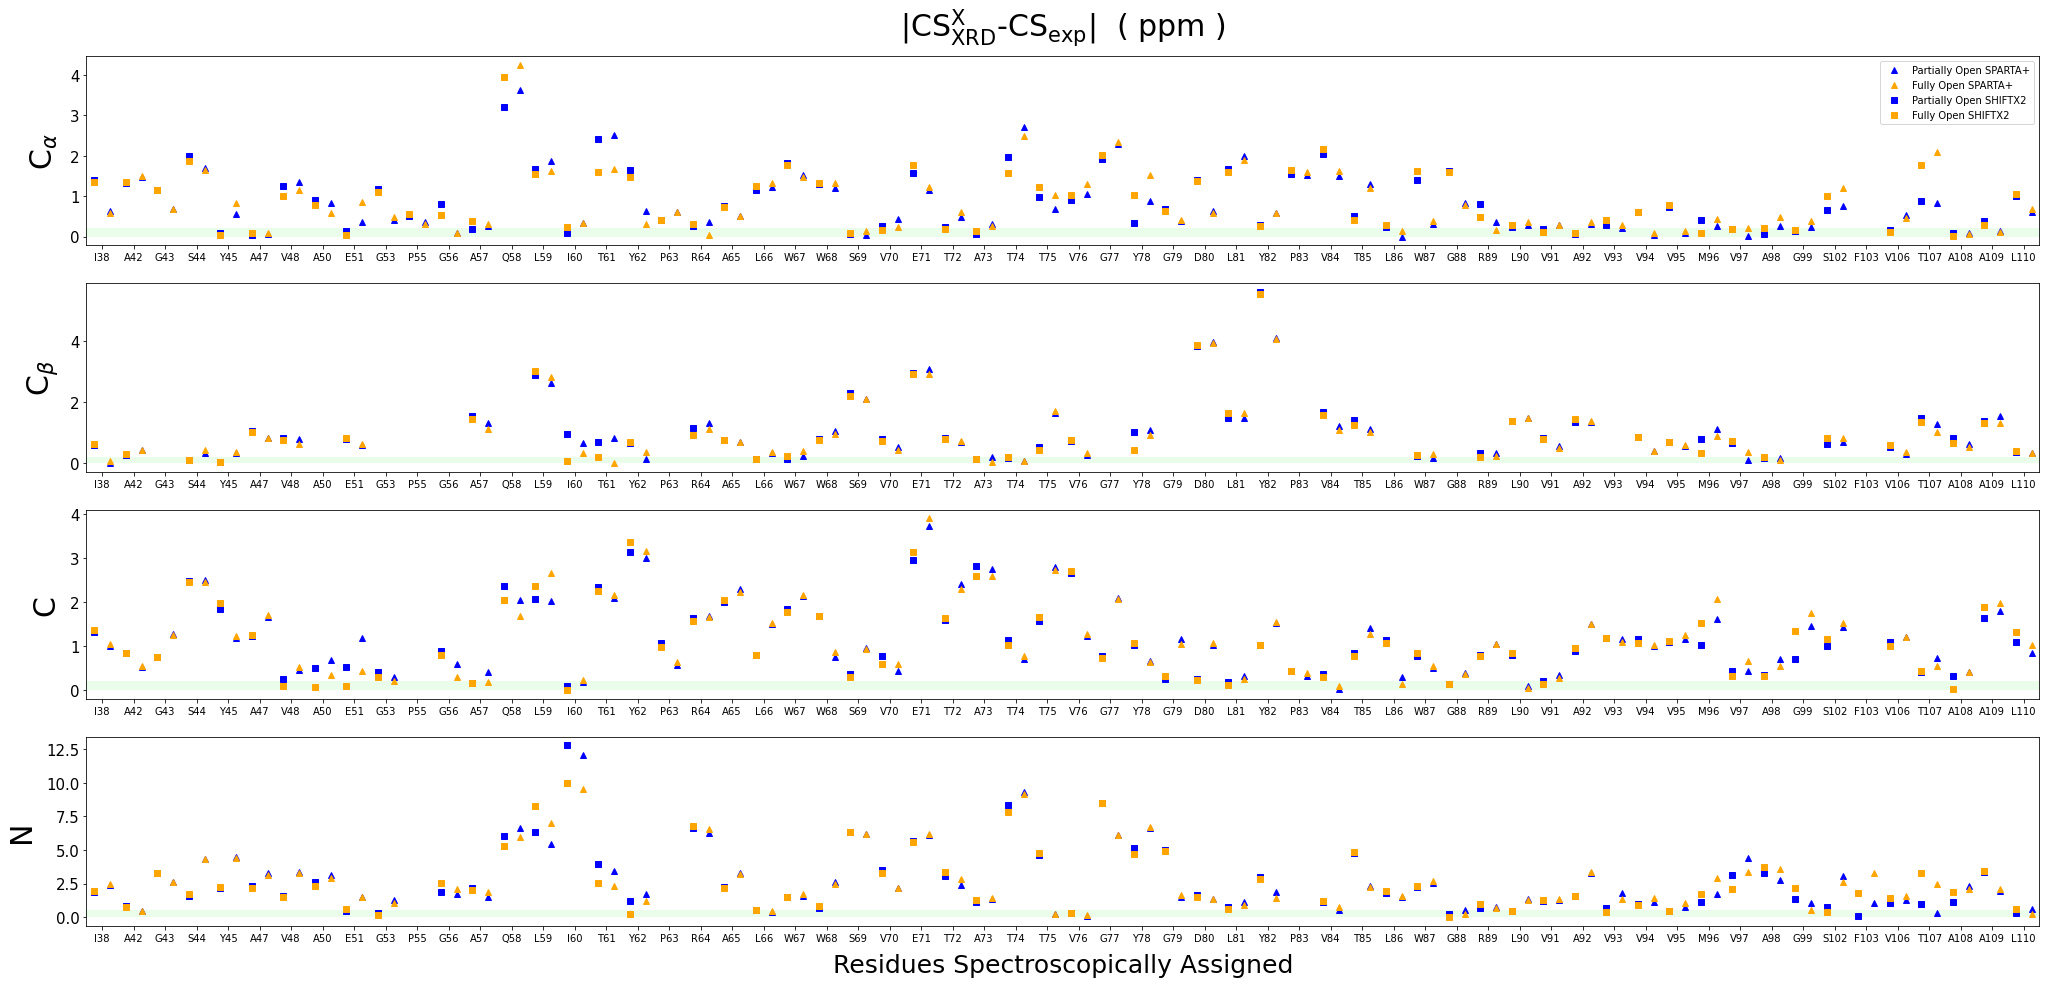

In [85]:
fig, ax = plt.subplots(4, 1, figsize=(35,16))
 

nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}
color_grey = 'gainsboro'

resids = list(set(data['CA']['sparta_plus']['resids']) |
              set(data['CB']['sparta_plus']['resids']) |
              set(data['N']['sparta_plus']['resids']) |
              set(data['C']['sparta_plus']['resids']) 
             )

resids = [ aa_dic[r]+str(r) for r in sorted([ int(r[1:]) for r in resids]) ]
x_to_aa = { a:j for j,a in enumerate(resids) }


for method, method_name, marker,shift in zip(['sparta_plus', 'shiftx2'],
                               ['SPARTA+', 'SHIFTX2'],
                               ['^','s'],
                                [+0.25, -0.25]
                                     ):
    for cutoff, i, nucleus in zip([0.2, 0.2, 0.2, 0.5], range(len(nuclei)) , nuclei): 
        aa = data[nucleus][method]['resids']
        y = data[nucleus][method]['Open'].mean() - data[nucleus][method]['Open exp'].mean()
        y = np.abs(y)
        x = np.array([x_to_aa[a] for a in aa])
        ax[i].plot(x+shift,y, ls ='', marker=marker, color='blue', label = f'Partially Open {method_name}')
        y = data[nucleus][method]['Fully Open'].mean() - data[nucleus][method]['Open exp'].mean()
        y = np.abs(y)
        ax[i].plot(x+shift,y, ls ='', marker=marker, color='Orange', label = f'Fully Open {method_name}')
        

        x = np.arange(len(resids))
        ax[i].set_xticks(x) # Set tick positions and corresponding labels
        _ = ax[i].set_xticklabels(resids, size=10)
        ax[i].set_ylabel(nuclei_to_name[nucleus], size=30, labelpad=10)
        ax[i].tick_params(axis='y', which='major', labelsize=15)
        ax[i].set_xlim([-0.5,len(x)-0.5])
        ax[i].axhspan(0,cutoff, facecolor='palegreen', alpha=.1)
        
ax[0].set_title(r'$|$CS$_\mathrm{XRD}^\mathrm{X}$-CS$_\mathrm{exp}|$  ( ppm )', size = 30, pad=20)
ax[-1].set_xlabel('Residues Spectroscopically Assigned', size=25, labelpad=10)
ax[0].legend()
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_all_print_no_ref_XRD.png', bbox_inches='tight')

## Correlation plots

In [132]:
methods = {}

In [133]:
nuclei = ['CA','CB','C','N']

In [134]:
for nucleus in nuclei:
    methods[nucleus] = {}
    for method in ['sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o', 'mean_fo'], 'my_mean', 'state',
        ['Open', 'Fully Open'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        methods[nucleus][method]= { 'data': my_model}

<ipython-input-134-8e282bb6b91d>:9: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


In [135]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [136]:
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}

In [137]:
plt.rcParams["text.usetex"] = False

In [138]:
plt.rcParams["axes.facecolor"] = "white" #"#EAEAF2"

In [140]:
df = pd.DataFrame()
for method in [ 'sparta_plus', 'shiftx2']:
    for nucleus in nuclei[:]:
        df_exp_o, df_3fb5, df_5vk6, df_5vkh, df_diff, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)
        df0 = pd.DataFrame()
        sim=az.summary(methods[nucleus][method]['data'])
        sim = (sim['hdi_97%'] + sim['hdi_3%'])/2.
        sim = sim.filter(axis=0,regex='my_mean')
        df0[r'CS$_{sim}$'] = sim
        df0.index = list(methods[nucleus][method]['data'].posterior.resid.to_series())*2
        df0 = df0.drop('W113', errors='ignore')
        resnum = [ int(res[1:]) for res in df0.index]
        df0[r'CS$_{exp}$'] = df_exp_o.T.loc[resnum].to_numpy()
        df0['State'] = 'Partially Open'
        df0['State'][df0.shape[0]//2+1:] = 'Fully Open'
        df0['method'] = method
        df0['Nucleus'] = nucleus
        df = pd.concat([df, df0])
df['Nucleus'] = df['Nucleus'].transform(lambda x: nuclei_to_name[x])

<ipython-input-140-190abec20d05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['State'][df0.shape[0]//2+1:] = 'Fully Open'
/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-140-190abec20d05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['State'][d

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


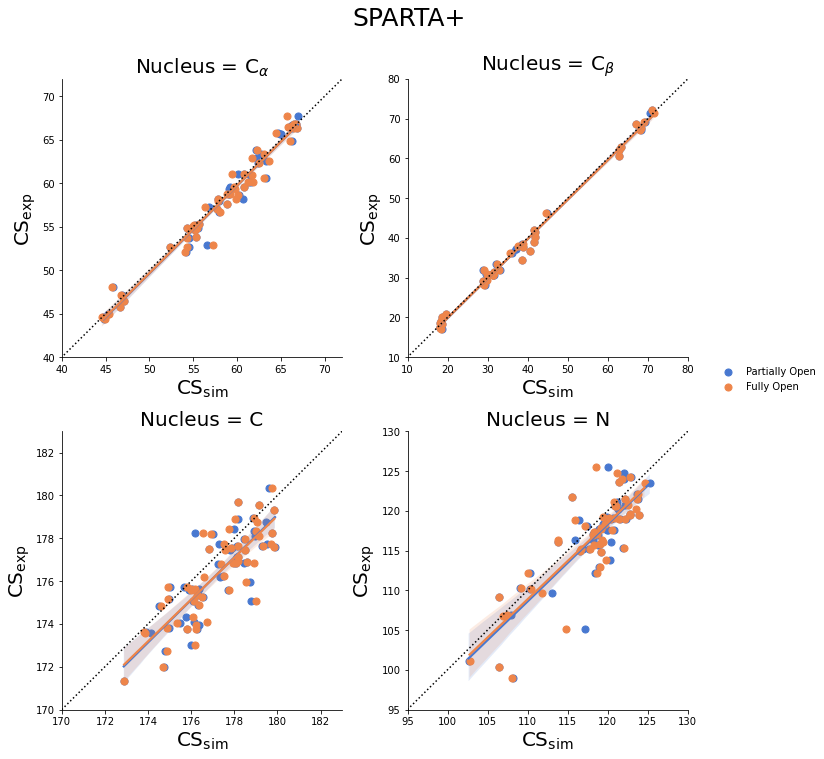

In [141]:
method = 'sparta_plus'
g = sns.lmplot(x=r'CS$_{sim}$', y=r'CS$_{exp}$', col="Nucleus", hue="State", data=df[df.method == method],
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}
           ,sharex=False,sharey=False, size = 5
              )
ax = g.axes
ax[0].set_ylim([40,72])
ax[0].set_xlim([40,72])
ax[1].set_ylim([10,80])
ax[1].set_xlim([10,80])
ax[2].set_ylim([170,183])
ax[2].set_xlim([170,183])
ax[3].set_ylim([95,130])
ax[3].set_xlim([95,130])
for a in ax:
    a.plot(np.arange(0,200,10),np.arange(0,200,10), color='k', ls = ':')
    a.set_xlabel(r'CS$_\mathrm{sim}$', size=20)
    a.set_ylabel(r'CS$_\mathrm{exp}$', size=20)
    a.title.set_size(20)
g.tight_layout()
g.legend.set_title("")
g.fig.suptitle(method_to_name[method], y=1.05, size = 25)
plt.savefig(f'{reports_dir}for_print/correlation_{method}_print.png')

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


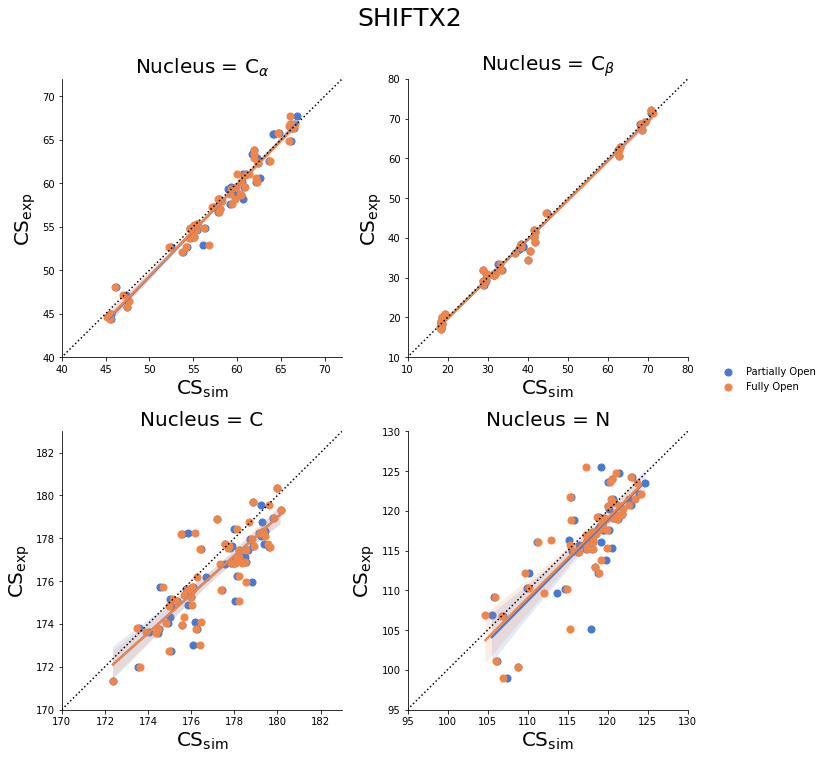

In [142]:
method = 'shiftx2'
g = sns.lmplot(x=r'CS$_{sim}$', y=r'CS$_{exp}$', col="Nucleus", hue="State", data=df[df.method == method],
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}
           ,sharex=False,sharey=False, size = 5
              )
ax = g.axes
ax[0].set_ylim([40,72])
ax[0].set_xlim([40,72])
ax[1].set_ylim([10,80])
ax[1].set_xlim([10,80])
ax[2].set_ylim([170,183])
ax[2].set_xlim([170,183])
ax[3].set_ylim([95,130])
ax[3].set_xlim([95,130])
for a in ax:
    a.plot(np.arange(0,200,10),np.arange(0,200,10), color='k', ls = ':')
    a.set_xlabel(r'CS$_\mathrm{sim}$', size=20)
    a.set_ylabel(r'CS$_\mathrm{exp}$', size=20)
    a.title.set_size(20)
g.tight_layout()
g.legend.set_title("")
g.fig.suptitle(method_to_name[method], y=1.05, size = 25)
plt.savefig(f'{reports_dir}for_print/correlation_{method}_print.png')

## Distribution of errors

In [21]:
methods = {}

In [22]:
nuclei = ['CA','CB','C','N']

In [23]:
for nucleus in nuclei:
    methods[nucleus] = {}
    print(nucleus)
    for method in [ 'sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c_abs', 'mean_fo_c_abs'], 'delta_delta_abs', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_o_abs', 'mean_fo_o_abs'], 'delta_delta_o_abs', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        methods[nucleus][method]= { 'data': my_model}

CA


<ipython-input-23-1f5fb33b005d>:13: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


CB
C
N


In [24]:
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}

In [25]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [26]:
state_to_name = {
    'mean_o_c': 'Partially Open',
    'mean_fo_c': 'Fully Open',
    'mean_o_o': 'Partially Open',
    'mean_fo_o': 'Fully Open',
}

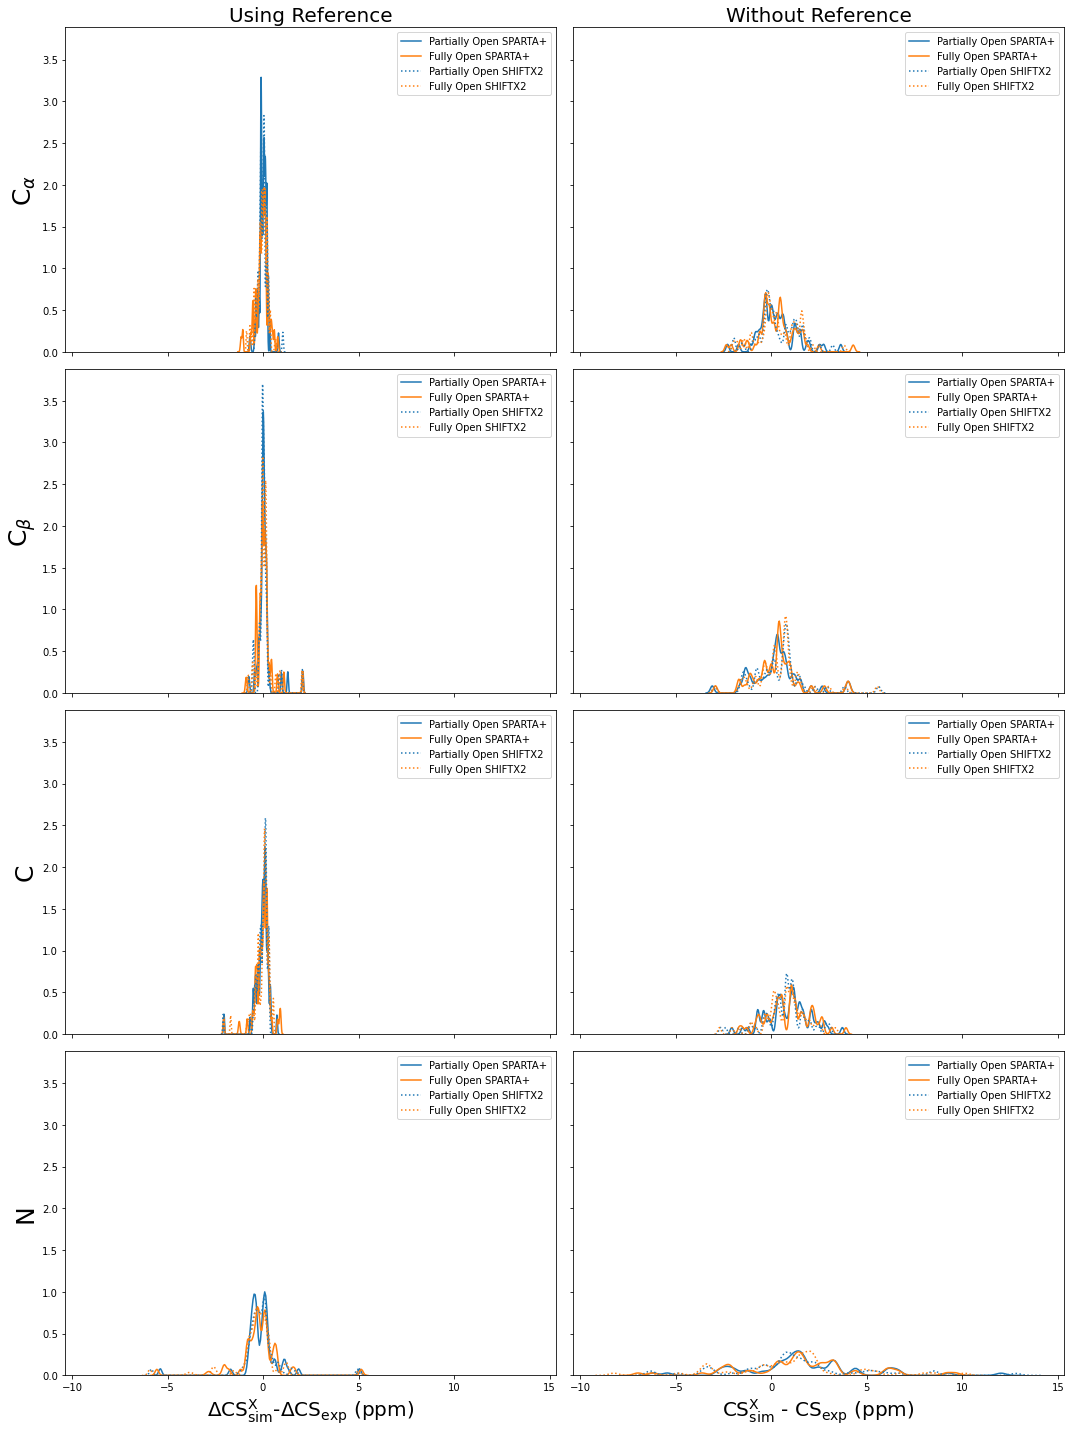

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(15,5*4), sharex=True, sharey=True)

for i, atom in enumerate(['CA', 'CB', 'C', 'N',]):
    for l, method in zip(['-',':'], method_to_name.keys()):
        for j, state in enumerate(['mean_o_c', 'mean_fo_c']):
            data = methods[atom][method]['data'].posterior[state].to_series().to_numpy()[:]
            sns.kdeplot(data=data, ax=ax[i,0], label=f'{state_to_name[state]} {method_to_name[method]}', ls=l, c=f'C{j}')
            ax[i,0].set_ylabel(nuclei_to_name[atom], size =25)
            ax[i,0].legend()
            ax[i,0].set_xlabel(r'$\Delta$CS$_\mathrm{sim}^\mathrm{X}$-$\Delta$CS$_\mathrm{exp}$ (ppm)', size =20)


for i, atom in enumerate(['CA', 'CB', 'C', 'N',]):
    for l, method in zip(['-',':'], method_to_name.keys()):
        for j, state in enumerate(['mean_o_o', 'mean_fo_o']):
            data = methods[atom][method]['data'].posterior[state].to_series().to_numpy()[:]
            sns.kdeplot(data=data, ax=ax[i,1], label=f'{state_to_name[state]} {method_to_name[method]}', ls=l, c=f'C{j}')
            ax[i,1].set_ylabel(nuclei_to_name[atom], size =25)
            ax[i,1].legend()
            ax[i,1].set_xlabel(r'CS$_\mathrm{sim}^\mathrm{X}$ - CS$_\mathrm{exp}$ (ppm)', size =20)

ax[0,0].set_title('Using Reference', size =20)
ax[0,1].set_title('Without Reference', size =20)
fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/error_distribution_print.png')

## Make table and Send Gsheets

### CS

In [65]:
data = {}

In [66]:
nuclei = ['CA','CB','C','N']

In [67]:
states = ['Fully Open', 'Partially Open', 'Closed']

In [68]:
methods = ['sparta_plus', 'shiftx2']

In [69]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [70]:
for nucleus in nuclei:
    data[nucleus] = {}
    for method in ['sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o', 'mean_fo', 'mean_c'], 'CS', 'state',
        ['Partially Open', 'Fully Open', 'Closed'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        data[nucleus][method]= { 'data': my_model}

<ipython-input-70-7883e4949653>:9: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


In [71]:
for nucleus in nuclei:
    series = []
    resids = data[nucleus][method]['data'].posterior.resid
    series.append(pd.Series(resids, name='resid'))
    for method in methods:
        for state in states:
            d = az.summary(data[nucleus][method]['data'].posterior['CS'].sel(state=state))
            center = (d['hdi_97%'] + d['hdi_3%'])/2
            err = d['hdi_97%'] - center
            series.append(pd.Series(format_plus_minus_error(center,err,format_value='.2f',
    format_error='.2f',), name=f'{state}, {method_to_name[method]}'))
    df = pd.DataFrame(series).T
    df_to_data_sheet(df,'KcsA_assignments',f'Sim. CS {nucleus}')

### |DeltaCS_sim -DeltaCS_exp| 

In [87]:
data = {}

In [88]:
nuclei = ['CA','CB','C','N']

In [89]:
states = ['Fully Open', 'Partially Open']

In [90]:
methods = ['sparta_plus', 'shiftx2']

In [91]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [92]:
for nucleus in nuclei:
    data[nucleus] = {}
    for method in ['sparta_plus', 'shiftx2']:
        model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
        my_model = az.from_netcdf(model_path)
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'delta delta', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = combine_posterior_variables(
        my_model.posterior, ['mean_o_o', 'mean_fo_o'], 'delta', 'state',
        ['Partially Open', 'Fully Open'])
        my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
        data[nucleus][method]= { 'data': my_model}

<ipython-input-92-3301834cccd2>:12: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')


In [93]:
for m in [ 'sparta_plus', 'shiftx2']:
    for c, a in zip([0.2, 0.2, 0.2, 0.5], nuclei):
        l = get_significant( models_dir + f"{model_name}_{m}_{a}.nc", ppm_cutoff=c)
        [ l.remove(amino_acid) for amino_acid in ['T33', 'V34','A111', 'T112'] if amino_acid in l ]
        data[a][m]['aa'] = l

In [94]:
resids = list(set(data['CA']['shiftx2']['aa']) | 
              set(data['CA']['sparta_plus']['aa']) | 
              set(data['CB']['shiftx2']['aa']) | 
              set(data['CB']['sparta_plus']['aa']) | 
              set(data['C']['shiftx2']['aa']) | 
              set(data['C']['sparta_plus']['aa']) | 
              set(data['N']['shiftx2']['aa']) | 
              set(data['N']['sparta_plus']['aa']) 
)

In [95]:
resids = data[nucleus]['sparta_plus']['data'].posterior.resid

In [96]:
for nucleus in nuclei:
    series = []
    for method in methods:
        aa = data[nucleus][method]['aa']
        for state in states:
            d = az.summary(data[nucleus][method]['data'].posterior['delta'].sel(state=state).loc[:,:,aa])
            center = (d['hdi_97%'] + d['hdi_3%'])/2
            err = d['hdi_97%'] - center
            series.append(pd.Series(format_plus_minus_error(center,err), name=f'{state}, {method_to_name[method]}',
                                   index=aa))
    for method in methods:
        aa = data[nucleus][method]['aa']
        for state in states:
            d = az.summary(data[nucleus][method]['data'].posterior['delta delta'].sel(state=state).loc[:,:,aa])
            center = (d['hdi_97%'] + d['hdi_3%'])/2
            err = d['hdi_97%'] - center
            series.append(pd.Series(format_plus_minus_error(center,err,format_value='.2f',
    format_error='.2f'), name=f'{state}, {method_to_name[method]}',
                                   index=aa))
    df = pd.DataFrame(series, columns=resids).T
    df = df.dropna(how='all').fillna('')
    df.reset_index(inplace=True)
    df_to_data_sheet(df,'KcsA_assignments',f'DeltaCSsim -DeltaCSexp {nucleus}')

## PPC

In [ ]:
method_to_name = {
    'sparta_plus': 'SPARTA+',
    'shiftx2': 'SHIFTX2'
}

In [ ]:
nuclei_to_name = {
    'CA': r'C$_\alpha$',
    'CB': r'C$_\beta$',
    'C': 'C',
    'N': 'N',
}

In [50]:
state_to_name = {
    'like_o' : 'Partially Open',
    'like_fo' : 'Fully Open',
    'like_c' : 'Closed',
}

In [54]:
%%ding
%%time
for nucleus in nuclei_to_name.keys():
    for method in method_to_name.keys():
        for state in state_to_name.keys():
            print(state)
            model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"
            my_model = az.from_netcdf(model_path)
            my_model.posterior = my_model.posterior.drop(['T33', 'V34','A111', 'T112'], dim='resid')
            my_model.posterior_predictive = my_model.posterior_predictive.drop(['T33', 'V34','A111', 'T112'], dim='resid')
            my_model.log_likelihood = my_model.log_likelihood.drop(['T33', 'V34','A111', 'T112'], dim='resid')
            my_model.observed_data = my_model.observed_data.drop(['T33', 'V34','A111', 'T112'], dim='resid')
            resids = my_model.posterior.resid
            n = resids.shape[0]
            fig, ax = plt.subplots(n // 6 + 1, 6, figsize=(13,15))
            for i in range(6 - n % 6):
                fig.delaxes(ax[-1,-i-1])
            ax = fig.axes
            with az.rc_context(rc={'plot.max_subplots': None}):
                az.plot_ppc(my_model, flatten=['step'], var_names = [state], random_seed=RANDOM_SEED, ax=ax)
            for r, a in zip(resids.to_index(), ax):
                a.set_title(f'{r}', size=12)
                a.set_xlabel('')
                a.legend_.set_visible(False)
            fig.suptitle(f'Posterior Predictive Check {method_to_name[method]} {nuclei_to_name[nucleus]} {state_to_name[state]} (ppm)', y =1.0, size =20)
            fig.tight_layout()
            plt.savefig(f'{reports_dir}for_print/ppc_{state}_{nucleus}_{method}.png')

like_o


<timed exec>:7: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
<timed exec>:8: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
<timed exec>:9: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
<timed exec>:10: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f122d673310> (for post_execute):


KeyboardInterrupt: 

KeyboardInterrupt: 

# Study the Simulations

## Occupation of SF

In [97]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                 'eq': 40,
                'title': 'Partially Open'},
          '5VK6_lb': {'begin': 0.,
                      'end': 350000.,
                      'eq': 40,
                'title': 'Fully Open'},
          '5VKH_lb': {'begin': 0,
                      'end': 1.e+20,
                      'eq': 100.,
                'title': 'Closed'}
         }

In [98]:
%cd /data/sperez/Projects/nmr_assign_state/notebooks/

/data/sperez/Projects/nmr_assign_state/notebooks


This cell calls the program of Kopec et al. from (https://doi.org/10.1038/s41467-019-13227-w) freely available in their supplementary data.

In [281]:
cdminus = os.getcwd()
for state in states.keys():
    print(state)
    spc_os.mkdir(processed_data_dir+state+'/SF_occupation')
    os.chdir(processed_data_dir+state+'/SF_occupation')
    myoutput = open("stdout",'w+')
    sp.run(f"../../../../../KcsA/Scripts/KopecProgram/xtck ../../../interim/{state}/all_pbc.gro ../../../interim/{state}/full_all_sk1_pbc_full.xtc",check=True,shell=True,stdout=myoutput)
    myoutput.close()
    os.chdir(cdminus)

3FB5_lb
5VK6_lb
5VKH_lb


In [99]:
def get_occupation(state):
    occupation = []
    occupation_labels = ['W', 'K', '0' ]
    
    sites = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5']
    with open(processed_data_dir+state+'/SF_occupation/stdout') as file:
        file = file.readlines()[23:-3]
        for line in file:
            occupation_split =[]
            for site in line.split()[4]:
                occupation_split.append(site)
            occupation.append(occupation_split)
    occupation = pd.DataFrame(occupation, columns=sites)
    for i, label in enumerate(occupation_labels):
        occupation[ occupation == label ] = i
    occupation = occupation.astype(int)
    return occupation, occupation_labels, sites

<ipython-input-100-bc2b29d5ae27>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  k.append( ax[i].pcolor(np.array(time),np.arange(len(sites)+1),occupation.T,cmap=plt.cm.get_cmap("tab20c", len(occupation_labels))))


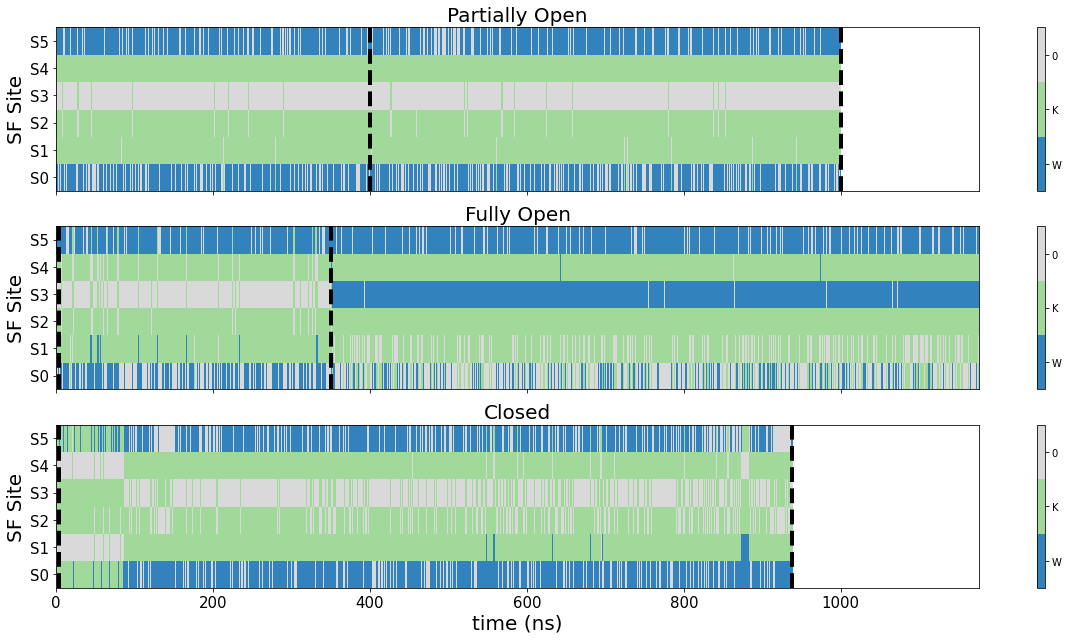

In [100]:
fig, ax = plt.subplots(3, 1,figsize = (17, 3*3), sharex=True)
k = []
occupation_labels_colorbar ={
        0.33 : 'W',
        1 : 'K',
        1.66: '0'
    }
for i, state in enumerate(states.keys()):
    occupation, occupation_labels, sites = get_occupation(state)
    time = occupation.index * 0.02
    k.append( ax[i].pcolor(np.array(time),np.arange(len(sites)+1),occupation.T,cmap=plt.cm.get_cmap("tab20c", len(occupation_labels))))
    formatter = plt.FuncFormatter(lambda val, loc: occupation_labels_colorbar[val])
    ax[i].set_ylabel('SF Site', size=20)
    ax[i].set_yticks(np.arange(len(sites))+0.5)
    ax[i].set_yticklabels([ f'S{j}' for j in np.arange(len(sites))])
    ax[i].tick_params(labelsize=15)
    title =states[state]['title']
    ax[i].set_title(title, size=20)
    plt.colorbar(k[i], ax=ax[i], ticks=[0.33,1,1.66],format=formatter)
ax[0].axvline(x=400,c="k", ls='--', lw=4)
ax[0].axvline(x=1000,c="k", ls='--', lw=4)
ax[1].axvline(x=3,c="k", ls='--', lw=4)
ax[1].axvline(x=350,c="k", ls='--', lw=4)
ax[2].axvline(x=3,c="k", ls='--', lw=4)
ax[2].axvline(x=938,c="k", ls='--', lw=4)
ax[-1].set_xlabel('time (ns)', size=20)
fig.tight_layout()
plt.savefig(f'{reports_dir}for_print/SF_occupation_print.png')

## Calculate Inner Gate distance

In [93]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                 'eq': 40,
                'title': 'Partially Open'},
          '5VK6_lb': {'begin': 0.,
                      'end': 350000.,
                      'eq': 40,
                'title': 'Fully Open'},
          '5VKH_lb': {'begin': 0,
                      'end': 1.e+20,
                      'eq': 100.,
                'title': 'Closed'},
          '3F5W_lb': {'begin': 0,
                      'end': 1.e+20,
                      'eq': 100.,
                'title': 'Ultra Open'}
         }

In [94]:
eq_time = { 
                 'Partially Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
    'Ultra Open': 70.
         }

In [95]:
df = pd.DataFrame()
n_roll = 50
for state in states.keys():
    print(state)
    u = mda.Universe(f'{raw_data_dir}{state}/charmm_final.pdb',[f'{interim_data_dir}{state}/eq0_all_sk1_pbc.xtc',
                                                                   f'{interim_data_dir}{state}/eq_all_sk1_pbc.xtc',
                                                                f'{interim_data_dir}{state}/all_sk1_pbc.xtc',
                                                                ])
    sel1 = u.select_atoms('resid 112 and segid PROA and name CA')
    sel2 = u.select_atoms('resid 112 and segid PROB and name CA')
    d = spc_analysis.distance_atoms(u, sel1, sel2)
    sel1 = u.select_atoms('resid 112 and segid PROC and name CA')
    sel2 = u.select_atoms('resid 112 and segid PROD and name CA')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    r = np.vstack([d,r])
    n = r.shape[0]
    df0 =  pd.DataFrame(r, columns=['t (ns)', r'r$_{IG}$ ($\AA$)'])
    df0['State'] = states[state]['title']
    df0['SU'] = pd.Series([ 'AB' for i in range(n//2)] + [ 'CD' for i in range(n//2)] )
    df = pd.concat([df, df0]) 

3FB5_lb


100%|██████████| 58877/58877 [03:25<00:00, 286.77it/s]


5VK6_lb


100%|██████████| 65343/65343 [03:02<00:00, 357.53it/s]


5VKH_lb


100%|██████████| 52207/52207 [02:52<00:00, 302.51it/s]


3F5W_lb


100%|██████████| 43762/43762 [01:45<00:00, 413.78it/s]


In [96]:
df.to_csv(processed_data_dir+'IG.csv')

In [174]:
df = pd.read_csv(processed_data_dir+'IG.csv')

In [175]:
df['t (ns)'] = df['t (ns)'] / 1000

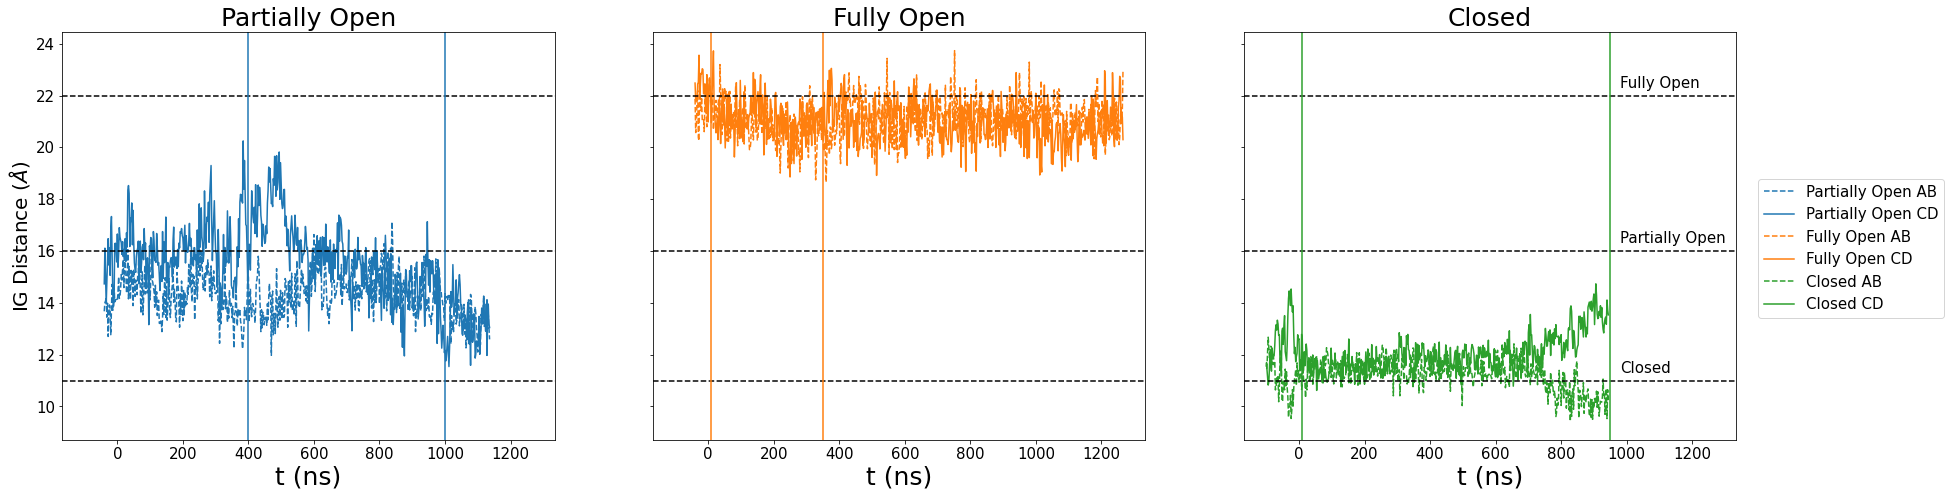

In [176]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7.5), sharex=True, sharey=True)
for i, state in enumerate(df.State.unique()[:-1]):
    for su, marker in zip(df.SU.unique(), ["--", "-"]):
        data = df[ np.logical_and(df.State == state, df.SU == su)]
        data = data.loc[::100,:]
        ax[i].plot(data['t (ns)']-eq_time[state], data['r$_{IG}$ ($\AA$)'], c=f'C{i}', ls = marker, label=f'{state} {su}', marker='')
    #ax[i].set_xlim([0.0, 1.5E3])
    ax[i].set_title(state, size=25)
    ax[i].set_xlabel('t (ns)', size=25)
    ax[i].axhline(y=11,c="black", ls='--')
    ax[i].axhline(y=16,c="black", ls='--')
    ax[i].axhline(y=22,c="black", ls='--')
    ax[i].tick_params(labelsize=15)
ax[0].set_ylabel(r'IG Distance ($\AA$)', size=20)
ax[2].text(980,11+0.3,'Closed',rotation=0, size=15)
ax[2].text(980,16+0.3,'Partially Open',rotation=0, size=15)
ax[2].text(980,22+0.3,'Fully Open',rotation=0, size=15)
ax[0].axvline(x=400,c="C0", ls='-')
ax[0].axvline(x=1000,c="C0", ls='-')
ax[1].axvline(x=10,c="C1", ls='-')
ax[1].axvline(x=350,c="C1", ls='-')
ax[2].axvline(x=10,c="C2", ls='-')
ax[2].axvline(x=950,c="C2", ls='-')
fig.legend(loc='right', fontsize=15)
plt.savefig(f'{reports_dir}for_print/IG_print.png')

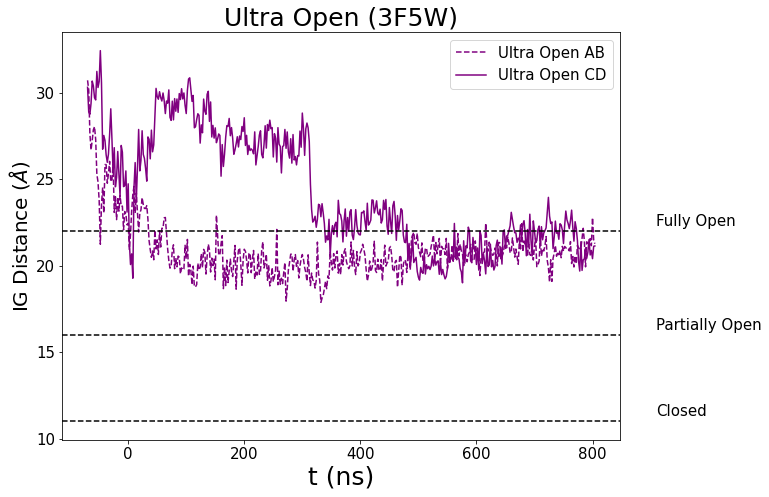

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), sharex=True, sharey=True)
i=0
state = 'Ultra Open'
for su, marker in zip(df.SU.unique(), ["--", "-"]):
    data = df[ np.logical_and(df.State == state, df.SU == su)]
    data = data.loc[::100,:]
    ax.plot(data['t (ns)']-eq_time[state], data['r$_{IG}$ ($\AA$)'], c=f'purple', ls = marker, label=f'{state} {su}', marker='')
#ax[i].set_xlim([0.0, 1.5E3])
ax.set_title(state+' (3F5W)', size=25)
ax.set_xlabel('t (ns)', size=25)
ax.axhline(y=11,c="black", ls='--')
ax.axhline(y=16,c="black", ls='--')
ax.axhline(y=22,c="black", ls='--')
ax.tick_params(labelsize=15)
ax.set_ylabel(r'IG Distance ($\AA$)', size=20)
ax.text(910,11+0.3,'Closed',rotation=0, size=15)
ax.text(910,16+0.3,'Partially Open',rotation=0, size=15)
ax.text(910,22+0.3,'Fully Open',rotation=0, size=15)
ax.legend(loc='best', fontsize=15)
plt.savefig(f'{reports_dir}for_print/IG_ultra_print.png', bbox_inches='tight')

## Calculate T61HB

In [31]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                 'eq': 40,
                'title': 'Partially Open'},
#           '5VK6_lb': {'begin': 0.,
#                       'end': 350000.,
#                       'eq': 40,
#                 'title': 'Fully Open'},
#           '5VKH_lb': {'begin': 0,
#                       'end': 1.e+20,
#                       'eq': 100.,
#                 'title': 'Closed'}
         }

In [32]:
eq_time = { 
                 'Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
         }

In [33]:
eq_time = { 
                 'Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
         }

In [47]:
df = pd.DataFrame()
n_roll = 100

for state in states.keys():
    print(state)
    u = mda.Universe(f'{raw_data_dir}{state}/charmm_final.pdb',[f'{interim_data_dir}{state}/eq0_all_sk1_pbc.xtc',
                                                                   f'{interim_data_dir}{state}/eq_all_sk1_pbc.xtc',
                                                                f'{interim_data_dir}{state}/all_sk1_pbc.xtc',
                                                                ])
    sel1 = u.select_atoms('resid 61 and segid PROA and name O')
    sel2 = u.select_atoms('resid 64 and segid PROA and name HN')
    d = spc_analysis.distance_atoms(u, sel1, sel2)
    sel1 = u.select_atoms('resid 61 and segid PROB and name O')
    sel2 = u.select_atoms('resid 64 and segid PROB and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROC and name O')
    sel2 = u.select_atoms('resid 64 and segid PROC and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROD and name O')
    sel2 = u.select_atoms('resid 64 and segid PROD and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    n = d.shape[0]
    df0 =  pd.DataFrame(d, columns=['t (ns)', r'r$_{61-64}$ ($\AA$)'])
    df0['State'] = states[state]['title']
    df0['SU'] = pd.Series([ 'A' for i in range(n//4)] + [ 'B' for i in range(n//4)] + [ 'C' for i in range(n//4)] + [ 'D' for i in range(n//4)])
    for u in ['A', 'B', 'C', 'D']:
        df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u] = df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u].rolling(n_roll).mean()[n_roll:]
    df = pd.concat([df, df0]) 

3FB5_lb


100%|██████████| 58877/58877 [02:40<00:00, 366.60it/s]
<ipython-input-47-1d12789981a7>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u] = df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u].rolling(n_roll).mean()[n_roll:]


In [48]:
df.to_csv(processed_data_dir+'HB61-64.csv')

In [49]:
df = pd.read_csv(processed_data_dir+'HB61-64.csv')

In [50]:
df['t (ns)'] = df['t (ns)'] / 1000

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


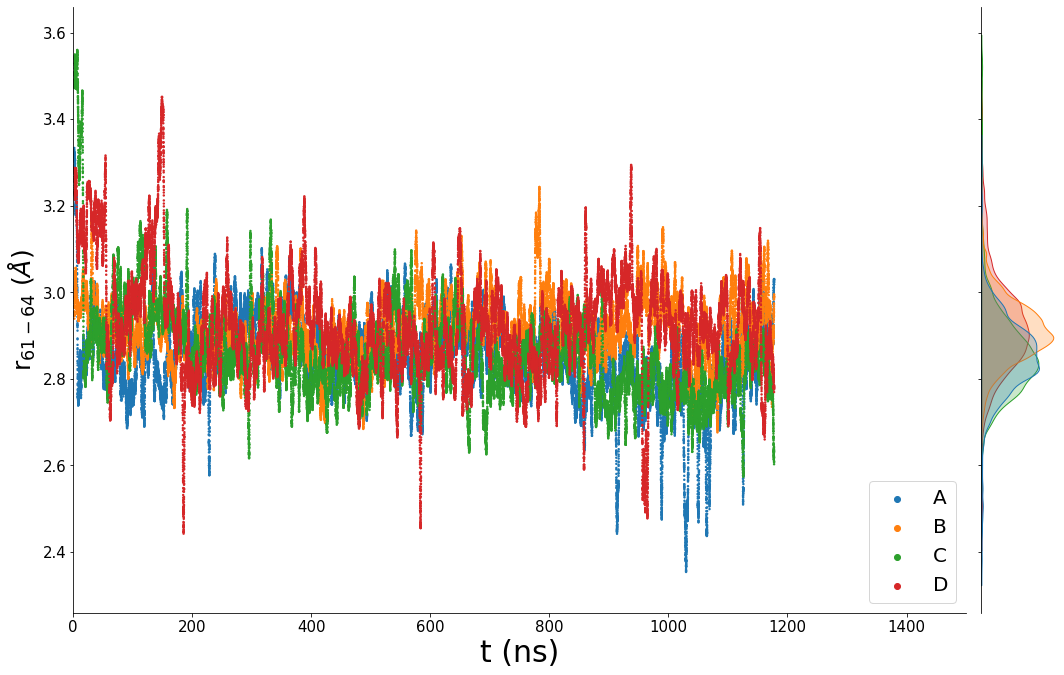

In [51]:
g = sns.jointplot("t (ns)", r'r$_{61-64}$ ($\AA$)', df.loc[::1,:], kind='scatter', hue='SU', markers='.',linewidth=0, s=6, height=10, ratio=10)
g.ax_marg_x.remove()
g.ax_joint.set_xlabel("t (ns)", size=30)
g.ax_joint.set_ylabel(r'r$_{61-64}$ ($\AA$)', size=25)
g.ax_joint.legend(fontsize=20, loc='lower right')
g.ax_joint.set_xlim([0.0, 1.5E3])
#g.ax_joint.set_ylim([0.0, 2.25])
g.fig.set_figwidth(15)
g.ax_joint.tick_params(labelsize=15)
plt.savefig(f'{reports_dir}for_print/HB61-64_print.png', bbox_inches='tight')

In [56]:
df = pd.DataFrame()
n_roll = 100

for state in states.keys():
    print(state)
    u = mda.Universe(f'{raw_data_dir}{state}/charmm_final.pdb',[f'{interim_data_dir}{state}/eq0_all_sk1_pbc.xtc',
                                                                   f'{interim_data_dir}{state}/eq_all_sk1_pbc.xtc',
                                                                f'{interim_data_dir}{state}/all_sk1_pbc.xtc',
                                                                ])
    sel1 = u.select_atoms('resid 61 and segid PROA and name OG1')
    sel2 = u.select_atoms('resid 64 and segid PROA and name CZ')
    d = spc_analysis.distance_atoms(u, sel1, sel2)
    sel1 = u.select_atoms('resid 61 and segid PROB and name OG1')
    sel2 = u.select_atoms('resid 6 and segid PROB and name CZ')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROC and name OG1')
    sel2 = u.select_atoms('resid 62 and segid PROC and name CZ')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROD and name OG1')
    sel2 = u.select_atoms('resid 62 and segid PROD and name CZ')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    n = d.shape[0]
    df0 =  pd.DataFrame(d, columns=['t (ns)', r'r$_{61-64}$ ($\AA$)'])
    df0['State'] = states[state]['title']
    df0['SU'] = pd.Series([ 'A' for i in range(n//4)] + [ 'B' for i in range(n//4)] + [ 'C' for i in range(n//4)] + [ 'D' for i in range(n//4)])
    for u in ['A', 'B', 'C', 'D']:
        df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u] = df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u].rolling(n_roll).mean()[n_roll:]
    df = pd.concat([df, df0]) 

3FB5_lb


100%|██████████| 58877/58877 [03:04<00:00, 319.43it/s]
<ipython-input-56-fa9293c5acfa>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u] = df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u].rolling(n_roll).mean()[n_roll:]


In [61]:
df.to_csv(processed_data_dir+'HB61-64sc.csv')

In [62]:
df = pd.read_csv(processed_data_dir+'HB61-64sc.csv')

In [63]:
df['t (ns)'] = df['t (ns)'] / 1000

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


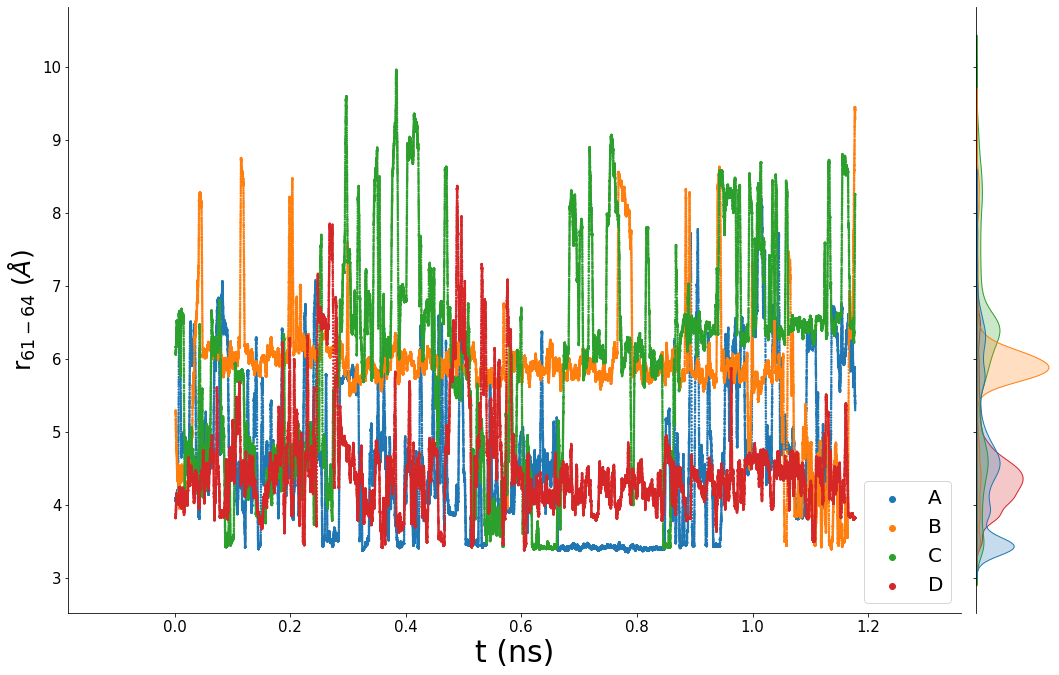

In [65]:
g = sns.jointplot("t (ns)", r'r$_{61-64}$ ($\AA$)', df.loc[::1,:], kind='scatter', hue='SU', markers='.',linewidth=0, s=6, height=10, ratio=10)
g.ax_marg_x.remove()
g.ax_joint.set_xlabel("t (ns)", size=30)
g.ax_joint.set_ylabel(r'r$_{61-64}$ ($\AA$)', size=25)
g.ax_joint.legend(fontsize=20, loc='lower right')
#g.ax_joint.set_xlim([0.0, 1.5E3])
#g.ax_joint.set_ylim([0.0, 2.25])
g.fig.set_figwidth(15)
g.ax_joint.tick_params(labelsize=15)
plt.savefig(f'{reports_dir}for_print/HB61-64sc_print.png', bbox_inches='tight')

In [52]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                 'eq': 40,
                'title': 'Open'},
#           '5VK6_lb': {'begin': 0.,
#                       'end': 350000.,
#                       'eq': 40,
#                 'title': 'Fully Open'},
#           '5VKH_lb': {'begin': 0,
#                       'end': 1.e+20,
#                       'eq': 100.,
#                 'title': 'Closed'}
         }

In [53]:
eq_time = { 
                 'Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
         }

In [54]:
eq_time = { 
                 'Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
         }

In [55]:
df = pd.DataFrame()
n_roll = 100

for state in states.keys():
    print(state)
    u = mda.Universe(f'{raw_data_dir}{state}/charmm_final.pdb',[f'{interim_data_dir}{state}/eq0_all_sk1_pbc.xtc',
                                                                   f'{interim_data_dir}{state}/eq_all_sk1_pbc.xtc',
                                                                f'{interim_data_dir}{state}/all_sk1_pbc.xtc',
                                                                ])
    sel1 = u.select_atoms('resid 61 and segid PROA and name O')
    sel2 = u.select_atoms('resid 65 and segid PROA and name HN')
    d = spc_analysis.distance_atoms(u, sel1, sel2)
    sel1 = u.select_atoms('resid 61 and segid PROB and name O')
    sel2 = u.select_atoms('resid 65 and segid PROB and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROC and name O')
    sel2 = u.select_atoms('resid 65 and segid PROC and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    sel1 = u.select_atoms('resid 61 and segid PROD and name O')
    sel2 = u.select_atoms('resid 65 and segid PROD and name HN')
    r = spc_analysis.distance_atoms(u, sel1, sel2)
    d = np.vstack([d,r])
    n = d.shape[0]
    df0 =  pd.DataFrame(d, columns=['t (ns)', r'r$_{61-65}$ ($\AA$)'])
    df0['State'] = states[state]['title']
    df0['SU'] = pd.Series([ 'A' for i in range(n//4)] + [ 'B' for i in range(n//4)] + [ 'C' for i in range(n//4)] + [ 'D' for i in range(n//4)])
    for u in ['A', 'B', 'C', 'D']:
        df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u] = df0[r'r$_{61-64}$ ($\AA$)'][df0['SU'] == u].rolling(n_roll).mean()[n_roll:]
    df = pd.concat([df, df0]) 

3FB5_lb


100%|██████████| 58877/58877 [02:57<00:00, 332.05it/s]


KeyError: 'r$_{61-64}$ ($\\AA$)'

In [ ]:
df.to_csv(processed_data_dir+'HB61-65.csv')

In [ ]:
df = pd.read_csv(processed_data_dir+'HB61-65.csv')

In [ ]:
df['t (ns)'] = df['t (ns)'] / 1000

In [ ]:
g = sns.jointplot("t (ns)", r'r$_{61-65}$ ($\AA$)', df.loc[::1,:], kind='scatter', hue='SU', markers='.',linewidth=0, s=6, height=10, ratio=10)
g.ax_marg_x.remove()
g.ax_joint.set_xlabel("t (ns)", size=30)
g.ax_joint.set_ylabel(r'r$_{61-65}$ ($\AA$)', size=25)
g.ax_joint.legend(fontsize=20, loc='lower right')
g.ax_joint.set_xlim([0.0, 1.5E3])
#g.ax_joint.set_ylim([0.0, 2.25])
g.fig.set_figwidth(15)
g.ax_joint.tick_params(labelsize=15)
plt.savefig(f'{reports_dir}for_print/HB61-64_print.png', bbox_inches='tight')

## Calculate RMSD

In [128]:
states = { 
    '3FB5_lb' : {'begin': 400000.,
                      'end': 1000000.,
                 'eq': 40,
                'title': 'Partially Open'},
          '5VK6_lb': {'begin': 0.,
                      'end': 350000.,
                      'eq': 40,
                'title': 'Fully Open'},
          '5VKH_lb': {'begin': 0,
                      'end': 1.e+20,
                      'eq': 100.,
                'title': 'Closed'}
         }

In [129]:
eq_time = { 
                 'Partially Open': 40,
                      'Fully Open': 40,
                      'Closed': 100.,
         }

In [130]:
df = pd.DataFrame()
n_roll = 50
for state in states.keys():
    print(state)
    u = mda.Universe(f'{raw_data_dir}{state}/charmm_final.pdb',[f'{interim_data_dir}{state}/eq0_all_sk1_pbc.xtc',
                                                               f'{interim_data_dir}{state}/eq_all_sk1_pbc.xtc',
                                                              f'{interim_data_dir}{state}/all_sk1_pbc.xtc',
                                                                ])
    r = spc_analysis.get_rmsd(u)
    df0 =  pd.DataFrame(r, columns=['t (ns)', r'RMSD ($\AA$)'])
    df0[r'RMSD ($\AA$)'] = df0[r'RMSD ($\AA$)'].rolling(n_roll).median()[n_roll:]
    df0['t (ns)'] = df0['t (ns)'][n_roll:] - states[state]['eq'] * 1000
    df0['State'] = states[state]['title']
    df0.iloc[0,1] = 0
    df0.iloc[0,0] = 0
    df = pd.concat([df, df0]) 

3FB5_lb
5VK6_lb
5VKH_lb


In [131]:
df.to_csv(processed_data_dir+'RMSD.csv')

In [132]:
df = pd.read_csv(processed_data_dir+'RMSD.csv')

In [133]:
df['t (ns)'] = df['t (ns)'] / 1000 

/home/sperez/data_partition/bin2/anaconda3/envs/nmr_assign_state/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


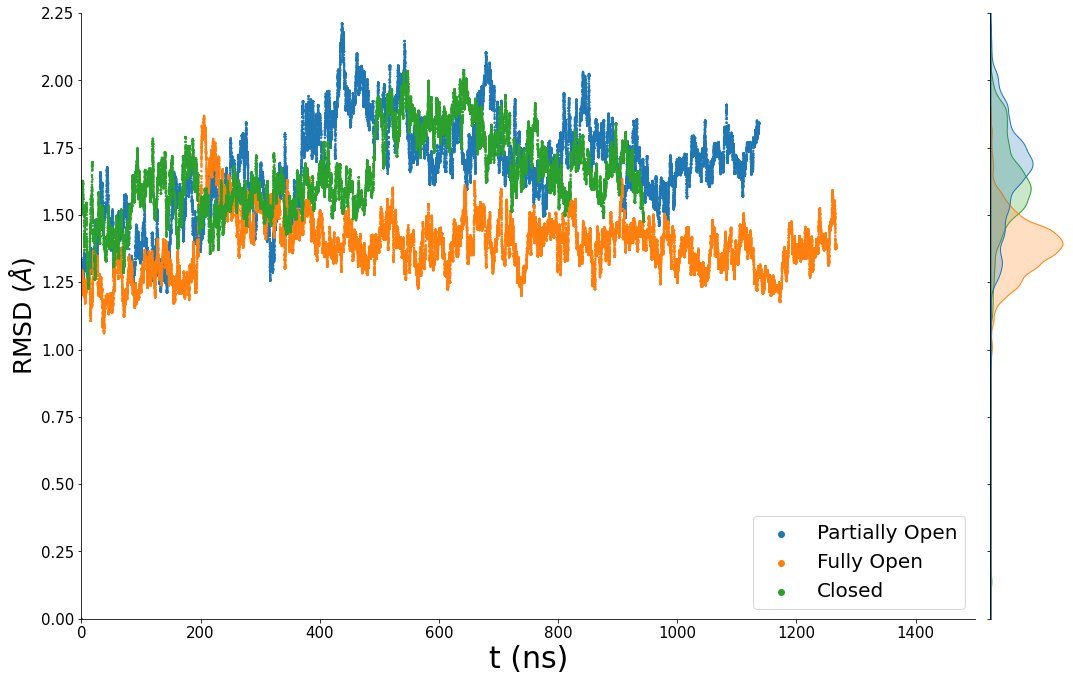

In [134]:
g = sns.jointplot("t (ns)", r'RMSD ($\AA$)', df.loc[::1,:], kind='scatter', hue='State', markers='.',linewidth=0, s=6, height=10, ratio=10)
g.ax_marg_x.remove()
g.ax_joint.set_xlabel("t (ns)", size=30)
g.ax_joint.set_ylabel(r'RMSD ($\AA$)', size=25)
g.ax_joint.legend(fontsize=20, loc='lower right')
g.ax_joint.set_xlim([0.0, 1.5E3])
g.ax_joint.set_ylim([0.0, 2.25])
g.fig.set_figwidth(15)
g.ax_joint.tick_params(labelsize=15)
plt.savefig(f'{reports_dir}for_print/RMSD_print.png', bbox_inches='tight')